In [1]:
import json
import csv
import tqdm
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statistics
from statistics import variance, stdev
import numpy as np
import csv
import requests
import json
import concurrent.futures

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
paper2ref = dict()
with open('./dataset/s2_paper_keys_for_references.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
      paper2ref[row[0]] = row[1:]

In [5]:
with open('./dataset/s2_paper_keys_to_paper_details_whole.json') as file:
  paper_details = json.load(file)

In [6]:
with open('./dataset/paperid_citationcount.json', 'r') as fp:
    dict_paperid_citationCount = json.load(fp)

In [7]:
paper_details

{'314107f8ff8bc134703c49c012ea6f6d9eb17840': {'title': 'Exploiting Auxiliary Data for Offensive Language Detection with Bidirectional Transformers',
  'acl_paper_key': 'singh-li-2021-exploiting',
  'paper_type': 'inproceedings',
  'venue': 'Proceedings of the 5th Workshop on Online Abuse and Harms (WOAH 2021)',
  'month': 'August',
  'year': '2021',
  'url': 'https://aclanthology.org/2021.woah-1.1',
  'authors': [['2133229826', 'Sumer Singh'], ['2153701736', 'Sheng Li']],
  'acl': True},
 'f1b3c81604806ac2d7be3a4d48ebfd41289eb104': {'title': 'Modeling Profanity and Hate Speech in Social Media with Semantic Subspaces',
  'acl_paper_key': 'hahn-etal-2021-modeling',
  'paper_type': 'inproceedings',
  'venue': 'Proceedings of the 5th Workshop on Online Abuse and Harms (WOAH 2021)',
  'month': 'August',
  'year': '2021',
  'url': 'https://aclanthology.org/2021.woah-1.2',
  'authors': [['144243797', 'Vanessa Hahn'],
   ['1412830188', 'Dana Ruiter'],
   ['1854885', 'Thomas Kleinbauer'],
   ['

In [8]:
paper2year = dict()
count = 0
for paper_id in tqdm.tqdm(paper2ref.keys()):
  if(paper_id in paper_details.keys()):
    if(paper_details[paper_id]['year'] != 'None'):
      year = int(paper_details[paper_id]['year'])
      paper2year[paper_id] = year
  else:
    count += 1
print(f'Number of papers for which details not present = {count} ')

100%|██████████| 73744/73744 [00:00<00:00, 471526.31it/s]

Number of papers for which details not present = 2074 


In [9]:
paper2year = dict()
for paper_id in paper_details.keys():
  if(paper_details[paper_id]['year'] != 'None'):
    year = int(paper_details[paper_id]['year'])
    paper2year[paper_id] = year

In [10]:
def citation_age(paper_id):
  reference_list = paper2ref[paper_id]
  citation_age_list = []
  mean_age = None
  year_published = None
  if(paper_id in paper2year.keys()):
    year_published = paper2year[paper_id]
    for reference in reference_list:
      if(reference in paper_details.keys() and reference in paper2year.keys()):
        reference_year = paper2year[reference]
        # print(f' {year_published} ---  {reference_year} ')
        age = year_published - reference_year
        if(age < 0 ):
          age = 0
        citation_age_list.append(age)
  if(len(citation_age_list) > 0):
    mean_age = sum(citation_age_list)/len(citation_age_list)
    # if(len(citation_age_list) == 1):
    #   mean_age = 0
    # else:
      # mean_age = variance(citation_age_list)
    # mean_age = mean_age/len(citation_age_list)
  return year_published, citation_age_list, mean_age

In [11]:
year2age  = dict()
year2mean_age = dict()
for paper_id in tqdm.tqdm(paper2ref.keys()):
  year, citation_age_list, mean_age = citation_age(paper_id)
  if(year != None):
    if(year not in year2age.keys()):
      year2age[year] = []
      year2mean_age[year] = []
    year2age[year].extend(citation_age_list)
    if(mean_age != None):
      year2mean_age[year].append(mean_age)

100%|██████████| 73744/73744 [00:01<00:00, 42713.02it/s]


In [12]:
year_variance = dict()
for year in range(1990, 2022):
# for year in year2age.keys():
  if(len(year2age[year]) <= 1):
    var = 0
  else:
    # print(f'Year =  {year} ::  count = {len(year2age[year])} ')
    var = stdev(year2age[year])
    # var = variance(year2age[year])
  year_variance[year] = var

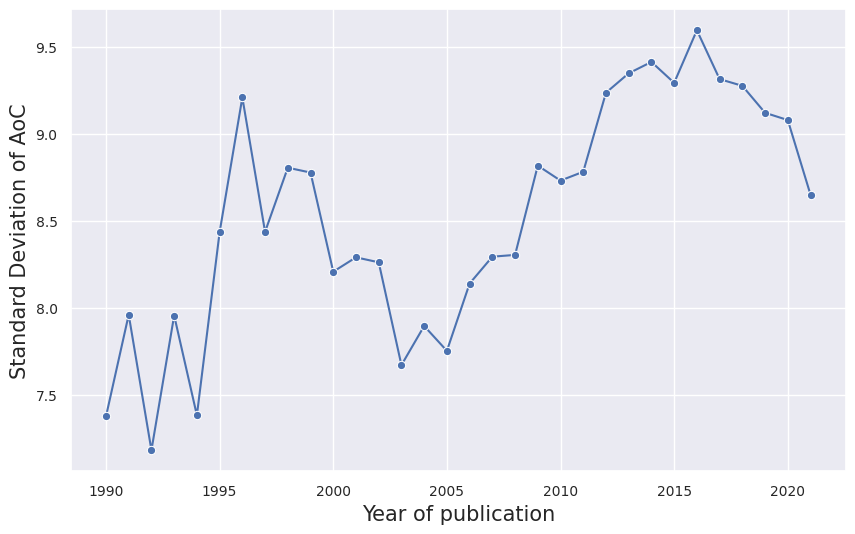

In [13]:
df_var = pd.DataFrame(year_variance.items(), columns=['Year', 'Variance'])
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(10,6)})
b = sns.lineplot(x = "Year", y = "Variance", data=df_var, marker="o")
b.set_xlabel("Year of publication",fontsize=15)
b.set_ylabel("Standard Deviation of AoC",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [14]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

year_citation_fraction = dict()
for year in range(1990, 2022):
  frac_list = []
  citation_list = year2age[year]
  citation_list = [x for x in citation_list if x <= 20]
  for i in range(20):
    frac = citation_list.count(i)/len(citation_list)
    frac_list.append(frac)
  year_citation_fraction[year] = frac_list

# year_citation_fraction[2022] = [0/30 for x in range(30)]
# year_citation_fraction[2023] = [1/20 for x in range(20)]
# year_citation_fraction[2022][5] = 1

year_gini = dict()
for year in range(1990, 2022):
  gini_coef = gini(np.array(year_citation_fraction[year]))
  year_gini[year] = gini_coef

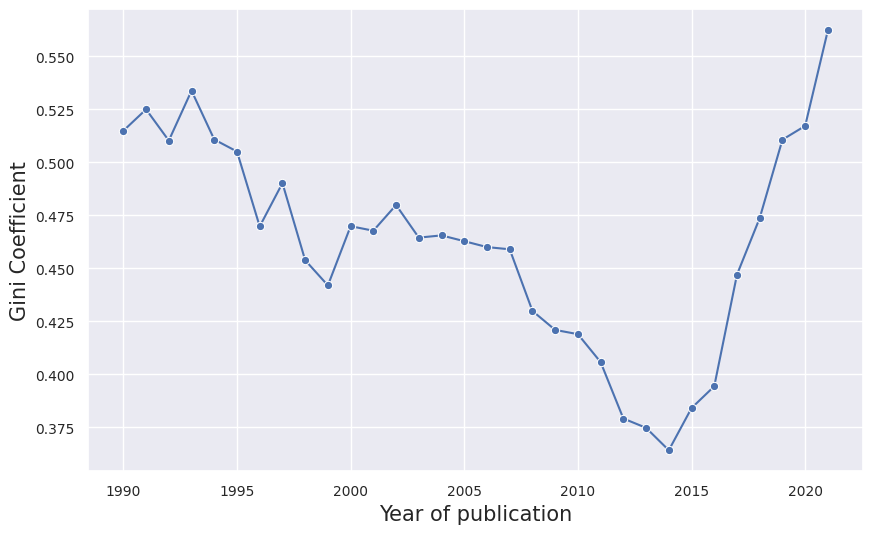

In [15]:
df_gini = pd.DataFrame(year_gini.items(), columns=['Year', 'Gini'])
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(10,6)})
b = sns.lineplot(x = "Year", y = "Gini", data=df_gini, marker="o")
b.set_xlabel("Year of publication",fontsize=15)
b.set_ylabel("Gini Coefficient",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [16]:
year_gini

{1990: 0.5149172046028628,
 1991: 0.5250238929595412,
 1992: 0.5102826710364604,
 1993: 0.5338286280336801,
 1994: 0.510793567558119,
 1995: 0.5051327150623599,
 1996: 0.4697884369870507,
 1997: 0.49021557613481115,
 1998: 0.45384370624920445,
 1999: 0.44194618154254306,
 2000: 0.46989763275751767,
 2001: 0.4677593145527714,
 2002: 0.47988347132781345,
 2003: 0.464504181600956,
 2004: 0.46555238984133224,
 2005: 0.4628219841877073,
 2006: 0.4600415537488706,
 2007: 0.4589897260273972,
 2008: 0.42991168500986865,
 2009: 0.42095348285273526,
 2010: 0.4189464786321128,
 2011: 0.4057622516052075,
 2012: 0.3791494301024594,
 2013: 0.3747530623969163,
 2014: 0.3641762790766195,
 2015: 0.3840783622787146,
 2016: 0.3943656158401627,
 2017: 0.44705216663694614,
 2018: 0.4737535087636948,
 2019: 0.5107246494285482,
 2020: 0.5172247297433157,
 2021: 0.5623495058890183}

In [17]:
# question X : what is the fraction of citations to articles that are at least ten years old

dict_old_citation_temp = dict()
for paper_id in tqdm.tqdm(paper2ref.keys()):
  if(paper_id in paper2year.keys()):
    year_published = paper2year[paper_id]
    if(year_published not in dict_old_citation_temp.keys()):
      dict_old_citation_temp[year_published] = dict()
      dict_old_citation_temp[year_published]['old'] = 0
      dict_old_citation_temp[year_published]['total'] = 0
    
    reference_list = paper2ref[paper_id]
    for reference in reference_list:
      if(reference in paper_details.keys() and reference in paper2year.keys()):
        reference_year = paper2year[reference]
        age = year_published - reference_year
        
        if(age < 0 ):
          age = 0

        if(age >= 10):
          dict_old_citation_temp[year_published]['old'] += 1
        
        dict_old_citation_temp[year_published]['total'] += 1

dict_old_citation = dict()
for year in dict_old_citation_temp.keys():
  if(year >= 1990):
    dict_old_citation[year] = (dict_old_citation_temp[year]['old'] /dict_old_citation_temp[year]['total'])*100

100%|██████████| 73744/73744 [00:02<00:00, 29932.33it/s]


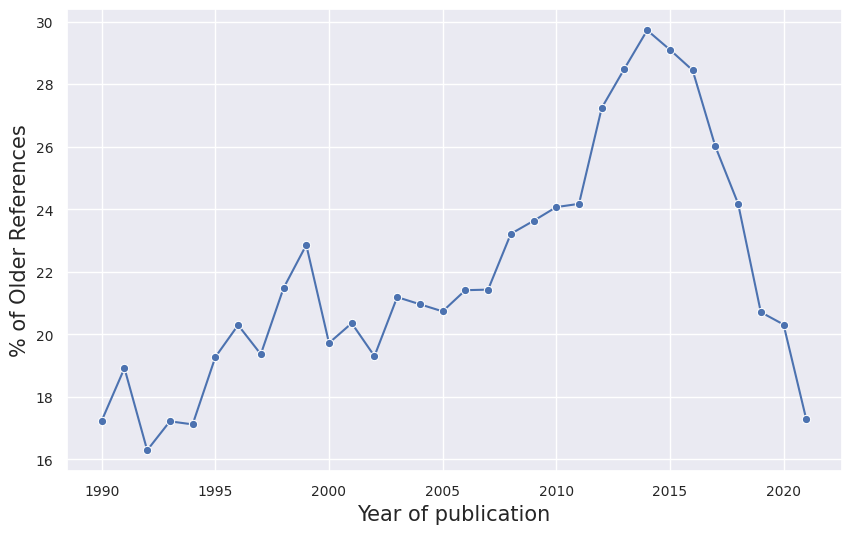

In [18]:
df_old = pd.DataFrame(dict_old_citation.items(), columns=['Year', 'count'])
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(10,6)})
b = sns.lineplot(x = "Year", y = "count", data=df_old, marker="o")
b.set_xlabel("Year of publication",fontsize=15)
b.set_ylabel("% of Older References",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=10)
plt.show()

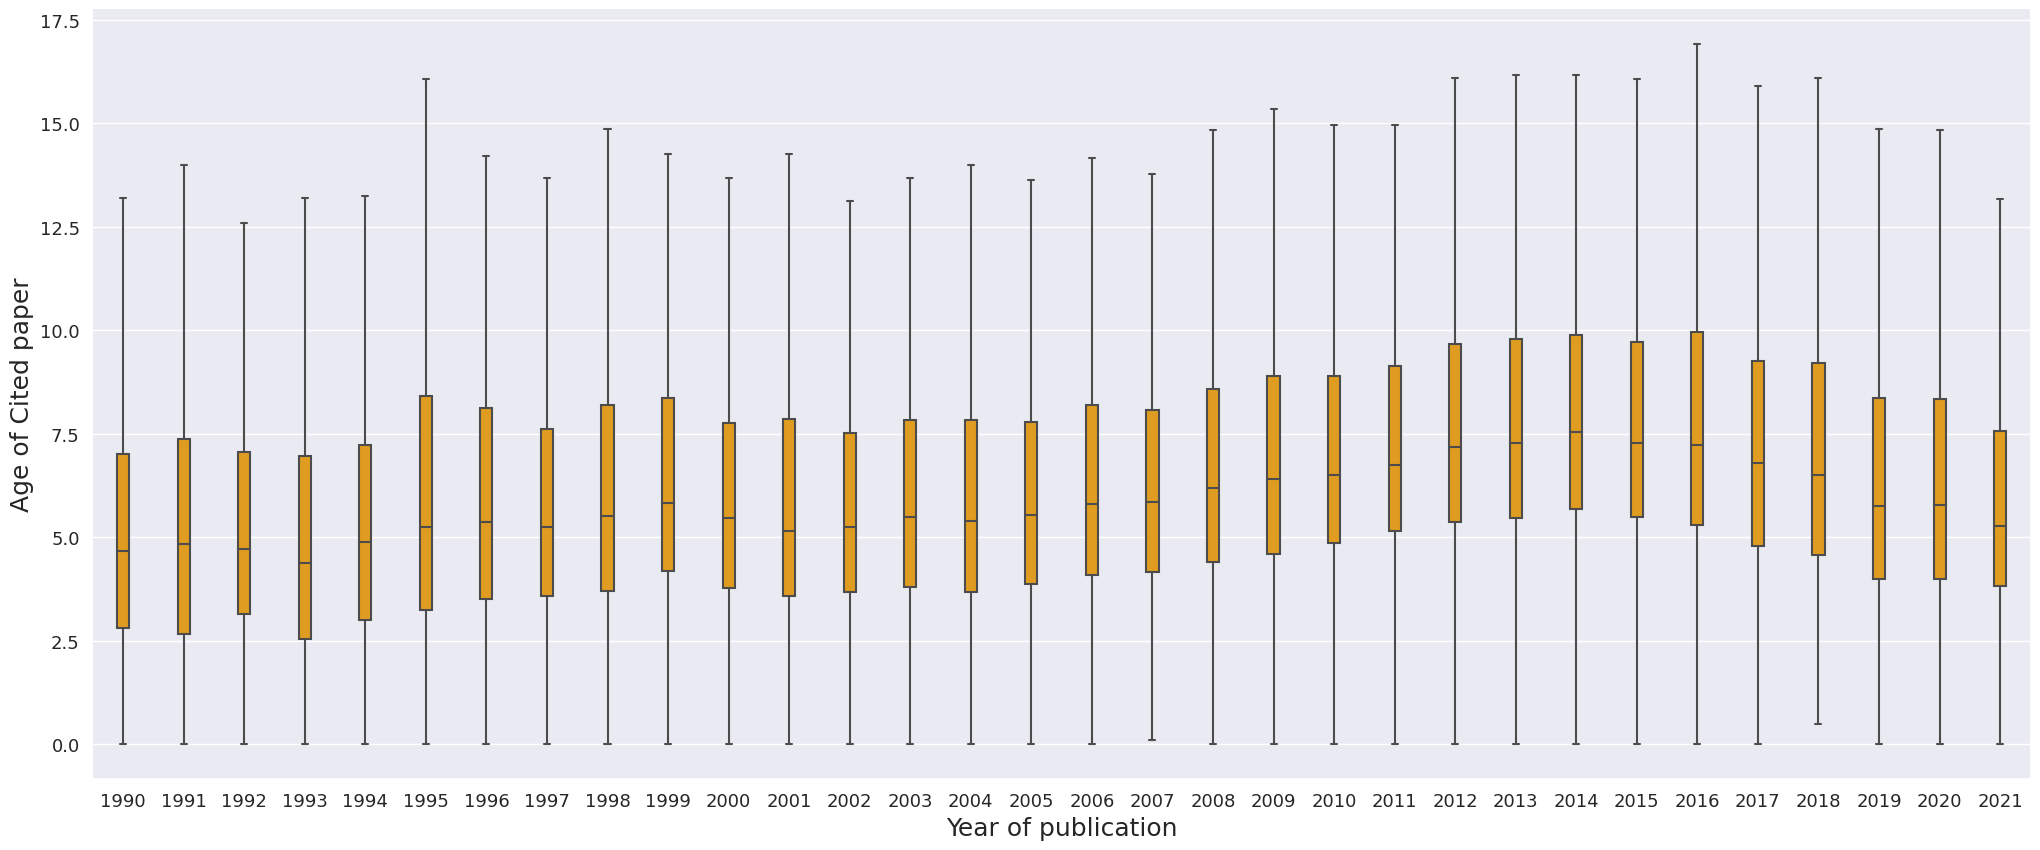

In [19]:
overall_df = []
for year in range(1990, 2022):
  dict1 = {'Age of Cited paper': year2mean_age[year], 'Year of publication': year} 
  df1 = pd.DataFrame(dict1)
  overall_df.append(df1)

overall_df = pd.concat(overall_df)
sns.set(rc={'figure.figsize':(25,10)})
# plt.ylim(-20, 200)
# sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], width = 0.2, showfliers = False)

b = sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], width = 0.2, showfliers = False, color="orange")
# b = sns.violinplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], inner="box", palette="colorblind", cut=2, linewidth=1.5, bw=0.10)
sns.despine(left=True)

b.set_xlabel("Year of publication",fontsize=18)
b.set_ylabel("Age of Cited paper",fontsize=18)
b.tick_params(axis='both', which='major', labelsize=13)
plt.show()

<ipython-input-20-c41878b4c855>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df_mean = overall_df_mean.append(df1, ignore_index=True)
<ipython-input-20-c41878b4c855>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df_mean = overall_df_mean.append(df1, ignore_index=True)
<ipython-input-20-c41878b4c855>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df_mean = overall_df_mean.append(df1, ignore_index=True)
<ipython-input-20-c41878b4c855>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df_mean = overall_df_mean.append(df1, ignore_index=True)
<ipython-input-20-c41878b4c855>:16: FutureWarning: The f

Text(0, 0.5, 'mean Age of Citations $\\mathit{(mAoC)}$ ')

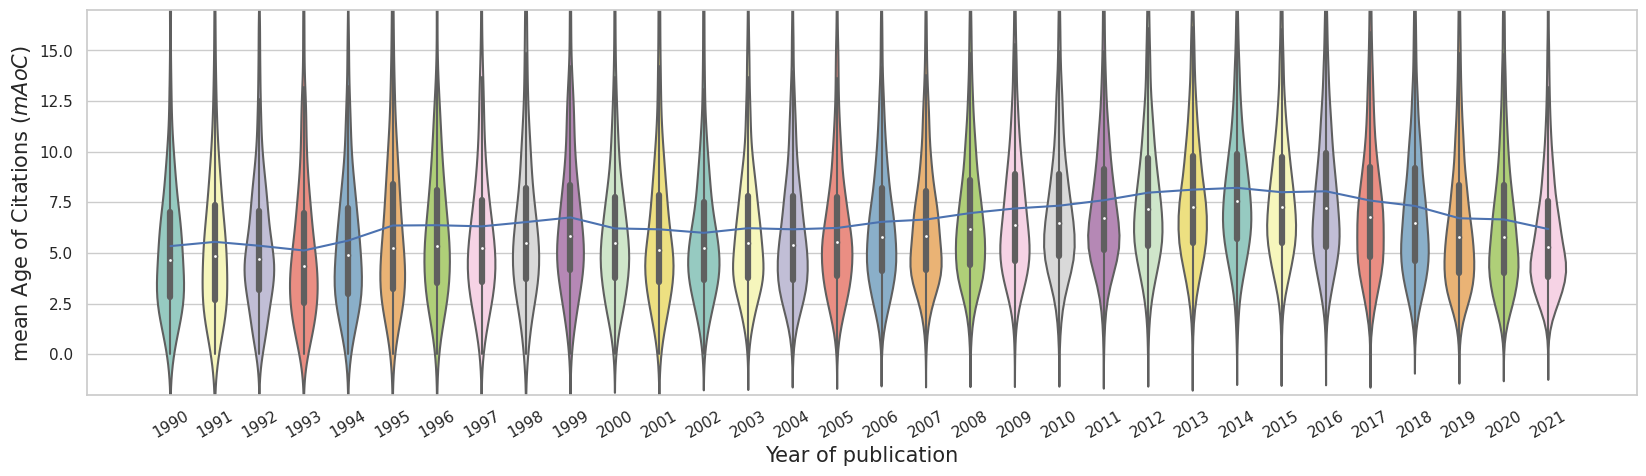

In [20]:
overall_df = []
for year in range(1990, 2022):
  dict1 = {'Age of Cited paper': year2mean_age[year], 'Year of publication': year} 
  df1 = pd.DataFrame(dict1)
  overall_df.append(df1)

overall_df = pd.concat(overall_df)
# sns.set(rc={'figure.figsize':(20.7,9.27)})
# sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], width = 0.2, showfliers = False)

#plot mean for each year
overall_df_mean = pd.DataFrame()
for year in range(1990, 2022):
  dict1 = {'Mean Age of Cited paper': [sum(year2mean_age[year]) / len(year2mean_age[year])], 'Year of publication': [year]} 
  df1 = pd.DataFrame(dict1)
  overall_df_mean = overall_df_mean.append(df1, ignore_index=True)

sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(20,5)})
sns.set_style(style='whitegrid')
# sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], width = 0.2, showfliers = False)

# b = sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], width = 0.2, showfliers = False)

fig,ax = plt.subplots()
plt.ylim(-2, 17)
# plt.xlim(0, None)
# ax = sns.lineplot(data = overall_df_mean, x='Year of publication', y='Mean Age of Cited paper', hue='type')
# ax = sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], width = 0.2, showfliers = False, color="orange")
ax = sns.violinplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], inner="box", palette="Set3", cut=2, linewidth=1.5)
ax.plot(overall_df_mean)
ax.tick_params(axis='x', rotation=30)

# b = sns.lineplot(data = overall_df_mean, x='Year of publication', y='Mean Age of Cited paper', hue='type')
# # b.set(xticks=df.Date.values)
# b.axes.set_title("Trend of Mean Age of cited paper for differnt years ",fontsize=20)
ax.set_xlabel("Year of publication",fontsize=15)
ax.set_ylabel("mean Age of Citations $\mathit{(mAoC)}$ ",fontsize=15)
# b.tick_params(axis='both', which='all', labelsize=10)
# plt.xticks(range(1990, 2022))
# # plt.show()


# b = sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], width = 0.2, showfliers = False, color="orange")
# b.axes.set_title("Distribution of Mean Age of cited paper for differnt years ",fontsize=20)
# b.set_xlabel("Year of publication",fontsize=15)
# b.set_ylabel("Age of Cited paper",fontsize=15)
# b.tick_params(axis='both', which='major', labelsize=10)
# plt.show()



In [21]:
# question 1 : what is the distribution of AoC
count_total = 0
count_present = 0
count_absent = 0
total = 0
dict_aoc_overall = dict() #stores key: age of citation, value: no. of references having that AoC
for paper_id in tqdm.tqdm(paper2ref.keys()):
  if(paper_id in paper2year.keys()):
    year_published = paper2year[paper_id]
    reference_list = paper2ref[paper_id]
    for reference in reference_list:
      if(reference in paper_details.keys() and reference in paper2year.keys()):
        reference_year = paper2year[reference]
        age = year_published - reference_year
        total += 1
        # if(age > 20):
        #   print(f'Year published = {year_published} --- reference_year {reference_year}')
        if(age < 0 ):
          age = 0
        if(age > 30):
          continue
        if(age not in dict_aoc_overall.keys()):
          dict_aoc_overall[age] = 0
        dict_aoc_overall[age] += 1

for key, value in dict_aoc_overall.items():
  dict_aoc_overall[key] = (value/total)*100

100%|██████████| 73744/73744 [00:02<00:00, 29091.70it/s]


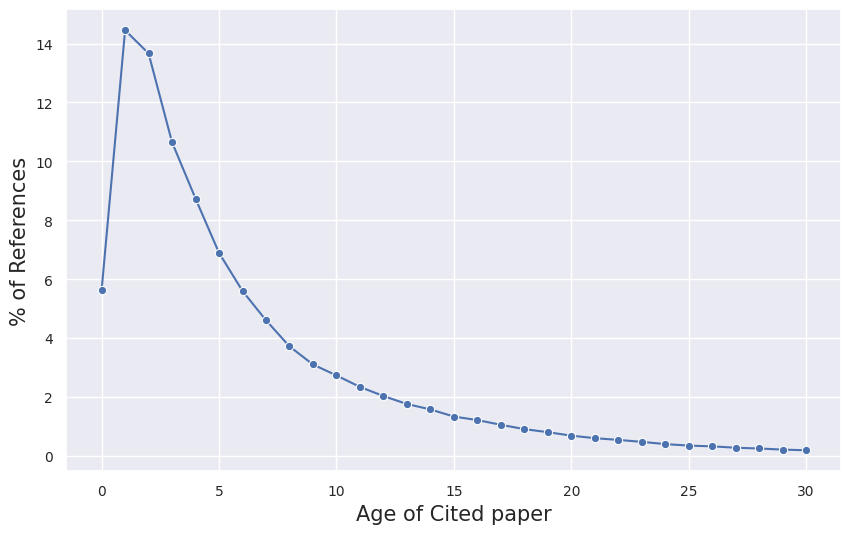

In [22]:
df_aoc = pd.DataFrame(dict_aoc_overall.items(), columns=['aoc', 'count'])
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(10,6)})
b = sns.lineplot(x = "aoc", y = "count", data=df_aoc, marker="o")
b.set_xlabel("Age of Cited paper",fontsize=15)
b.set_ylabel("% of References",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [23]:
#question 4
list_number_of_ref = []
for paper_id in tqdm.tqdm(paper2ref.keys()):
  list_number_of_ref.append(len(paper2ref[paper_id]))

print(f'Average number of papers referenced by an AA paper = {sum(list_number_of_ref)/len(list_number_of_ref)}')

dict_count_reference_year = dict()
for paper_id in tqdm.tqdm(paper2ref.keys()):
  if(paper_id in paper2year.keys()): 
    year_published = paper2year[paper_id]
    reference_list = paper2ref[paper_id]
    count_ref = len(reference_list)
    if(year_published not in dict_count_reference_year.keys()):
      dict_count_reference_year[year_published] = []
    dict_count_reference_year[year_published].append(count_ref)

dict_avg_reference_year = dict()
for year, list_count_ref in dict_count_reference_year.items():
  avg_year = sum(list_count_ref)/len(list_count_ref)
  dict_avg_reference_year[year] = avg_year

100%|██████████| 73744/73744 [00:00<00:00, 368296.24it/s]


Average number of papers referenced by an AA paper = 20.638831633760034


100%|██████████| 73744/73744 [00:00<00:00, 306989.44it/s]


In [24]:
dict_avg_reference_year

{2021: 30.461737017916793,
 2005: 13.965601965601966,
 2020: 29.47991452991453,
 2009: 17.349363507779348,
 2016: 22.698408812729497,
 2012: 19.343406593406595,
 2019: 27.758705955079332,
 2010: 17.275582573454916,
 2015: 23.31861533027199,
 2018: 26.050674928081435,
 2006: 14.663755458515285,
 2014: 21.496867881548976,
 2017: 24.898210980876,
 2011: 19.66545123062899,
 2013: 22.01581463773446,
 1993: 9.308617234468938,
 2001: 11.140442132639793,
 2007: 14.284472049689441,
 2008: 15.289201877934273,
 2002: 12.120851063829788,
 1999: 11.639376218323587,
 1994: 9.563063063063064,
 2003: 12.232888888888889,
 1992: 9.370242214532873,
 1997: 11.60374414976599,
 2000: 11.567139282735614,
 1998: 10.699879951980792,
 2004: 11.939181916038752,
 1959: 3.0,
 1996: 10.50513698630137,
 1995: 9.723287671232876,
 1989: 7.642651296829971,
 1990: 8.29045643153527,
 1991: 9.143222506393862,
 1987: 6.92,
 1988: 9.778688524590164,
 1986: 7.037414965986395,
 1985: 7.856209150326797,
 1983: 8.13138686131387

In [25]:
print(f'Mean number of references for ALL the papers = {statistics.mean(list_number_of_ref)} ')
print(f'Median number of references for ALL the papers = {statistics.median(list_number_of_ref)} ')
print(f'Mode number of references for ALL the papers = {statistics.mode(list_number_of_ref)} ')

Mean number of references for ALL the papers = 20.638831633760034 
Median number of references for ALL the papers = 18.0 
Mode number of references for ALL the papers = 1 


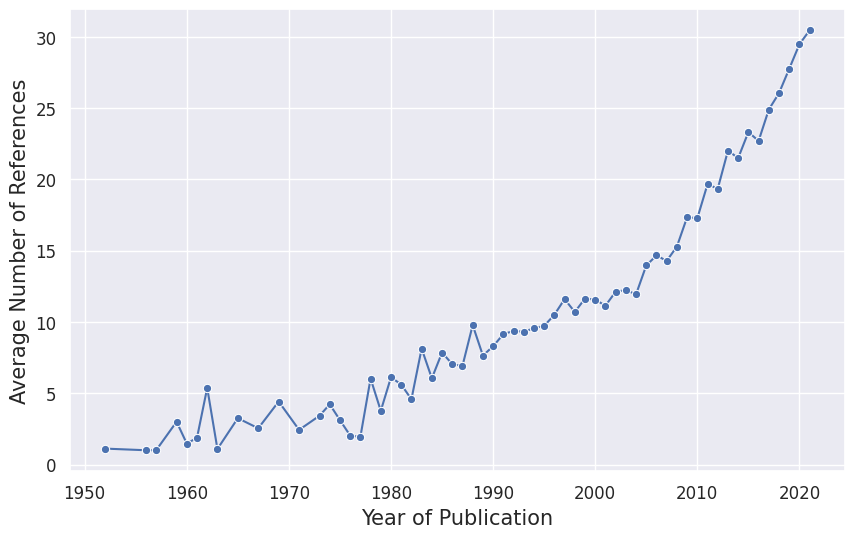

In [26]:
df_avg_ref = pd.DataFrame(dict_avg_reference_year.items(), columns=['year', 'reference'])
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(10,6)})
b = sns.lineplot(x = "year", y = "reference", data=df_avg_ref, marker="o")
b.set_xlabel("Year of Publication",fontsize=15)
b.set_ylabel("Average Number of References",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=12)
plt.show()

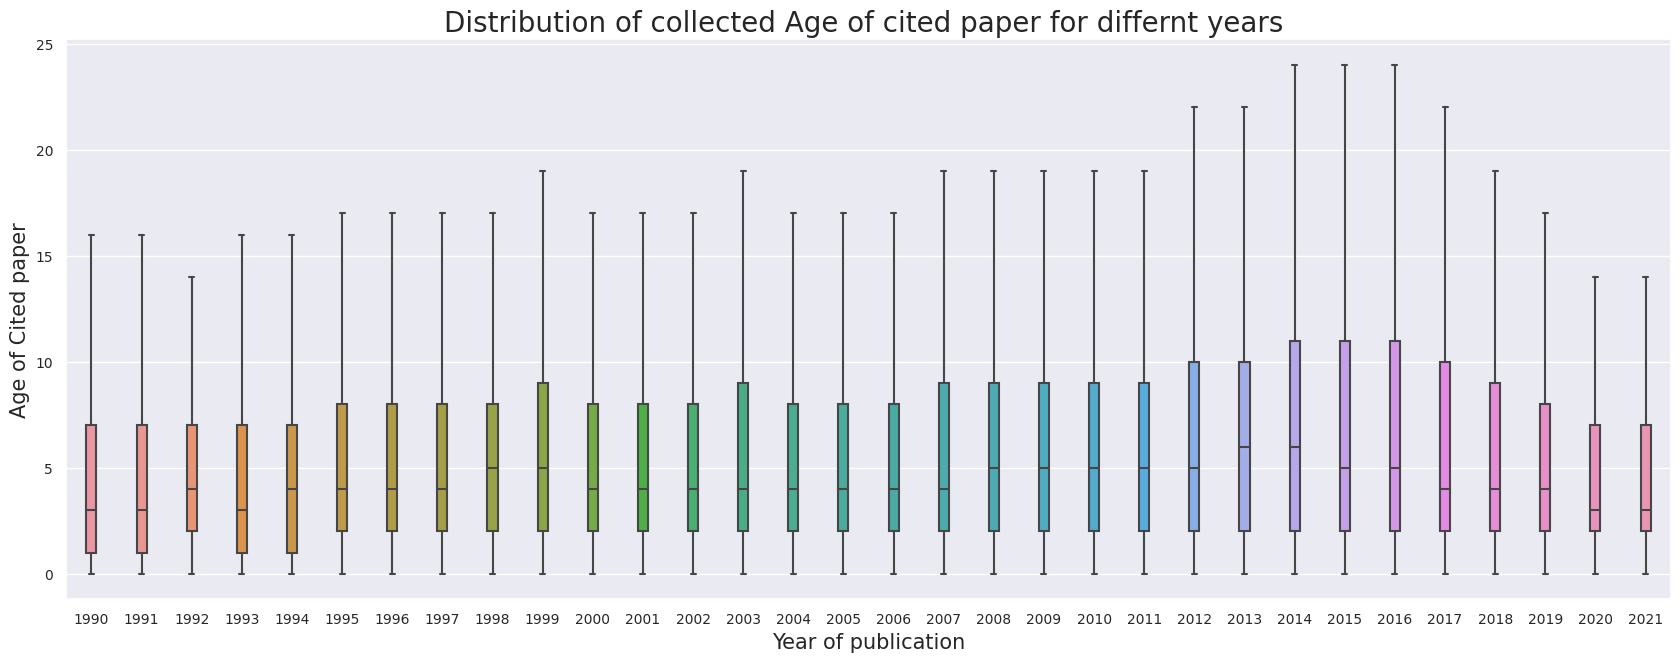

In [27]:
overall_df = []
for year in range(1990, 2022):
  dict1 = {'Age of Cited paper': year2age[year], 'Year of publication': year} 
  df1 = pd.DataFrame(dict1)
  overall_df.append(df1)

overall_df = pd.concat(overall_df)
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(20.7,7.27)})
# sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], width = 0.2, showfliers = False)

b = sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], width = 0.2, showfliers = False)
b.axes.set_title("Distribution of collected Age of cited paper for differnt years ",fontsize=20)
b.set_xlabel("Year of publication",fontsize=15)
b.set_ylabel("Age of Cited paper",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=10)
plt.show()

<Axes: xlabel='year', ylabel='data'>

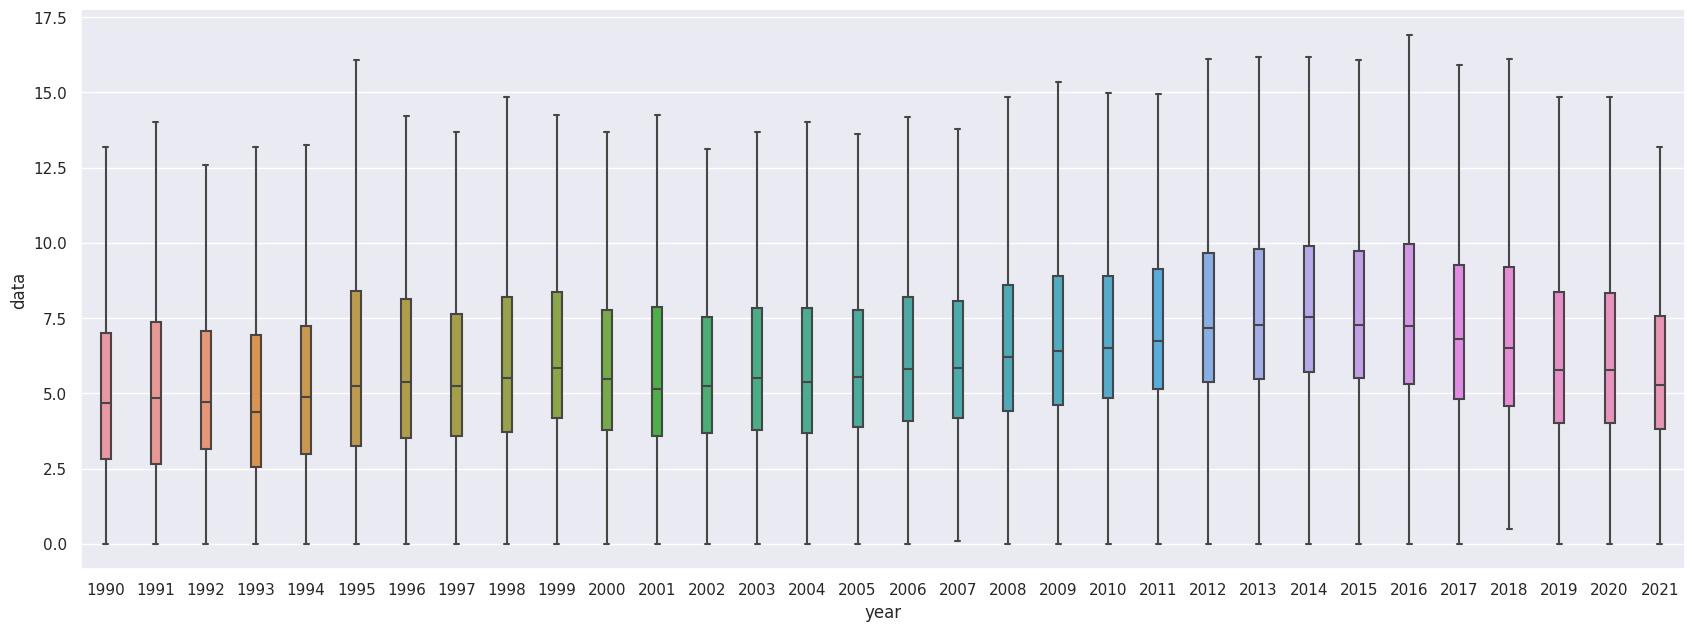

In [28]:
overall_df = []
for year in range(1990, 2022):
  dict1 = {'data': year2mean_age[year], 'year': year} 
  df1 = pd.DataFrame(dict1)
  overall_df.append(df1)

overall_df = pd.concat(overall_df)
sns.set(rc={'figure.figsize':(20.7,7.27)})
sns.boxplot(x= overall_df['year'], y=overall_df['data'], width = 0.2, showfliers = False)

In [30]:
def get_venue():
    conference_names = dict()
    conference_names['CL'] = 'computational linguistics'
    conference_names['TACL'] = 'transactions of the association for computational linguistics'

    conference_names['ACL'] = 'annual meeting of the association for computational linguistics'
    conference_names['CONLL'] = 'Conference on Computational Natural Language Learning'
    conference_names['COLING'] = 'international Conference on Computational Linguistics'
    conference_names['EACL'] = 'European Chapter of the Association for Computational Linguistics'
    conference_names['EMNLP'] = 'Conference on Empirical Methods in Natural Language Processing'
    conference_names['Findings'] = 'Findings of the Association for Computational Linguistics'
    conference_names['NAACL'] = 'North American Chapter of the Association for Computational Linguistics'

    #conference_names['SEMEVAL'] = 'international workshop on semantic evaluation'
    # conference_names['WMT'] = ['Workshop on Statistical Machine Translation', 'Conference on Machine Translation']
    conference_names['IJCNLP'] = 'International Joint Conference on Natural Language Processing'
    conference_names['LREC'] = 'Language Resources and Evaluation'
    conference_names['PACLIC'] = 'Pacific Asia Conference on Language, Information and Computation'
    conference_names['ROCLING'] = 'Conference on Computational Linguistics and Speech Processing'
    conference_names['RANLP'] = 'International Conference Recent Advances in Natural Language Processing'
    conference_names['workshop'] = "workshop"

    #convert to lower case:
    for key in conference_names.keys():
        conference_names[key] = conference_names[key].lower()
    
    dict_venue_to_paper_id = dict()
    special_characters = ['!','#','$','%','&','@','[',']',']','_','{','}',',','.',':','\\']
    venue_list = []
    for paper_id in paper_details.keys():
        venue = paper_details[paper_id]['venue']
        venue = ''.join(filter(lambda i:i not in special_characters, venue))
        venue_list.append(venue)
    unique_venues = sorted(list(set(venue_list)))
    

    # get the dict[paper_id] -> venue
    dict_paper_id_to_venue = dict()
    for paper_id in paper_details.keys():
        venue = paper_details[paper_id]['venue']
        venue_processed = venue.lower()
        venue_processed = ''.join(filter(lambda i:i not in special_characters, venue_processed))
        venue = ""
        for key in conference_names.keys():
            if(conference_names[key] in venue_processed):
                venue  = key
            if(key == 'CL'):
                if(conference_names[key] == venue_processed):
                    venue = key
        # if(venue not in dict_venue_to_paper_id.keys()):
        #     dict_paper_id_to_venue[citenet.paper_features[paper_id]['paper_key']] = []
        dict_paper_id_to_venue[paper_id] = venue
    return dict_paper_id_to_venue

dict_paper_id_to_venue = get_venue()

In [31]:
unique_venues = dict()
for paper_id in dict_paper_id_to_venue.keys():
  if(dict_paper_id_to_venue[paper_id] not in unique_venues.keys()):
    unique_venues[dict_paper_id_to_venue[paper_id]] = 0
  unique_venues[dict_paper_id_to_venue[paper_id]] += 1

# unique_venues = set(unique_venues)

In [32]:
#coarse view of venues Journal, conferences and workshops
journals = ['TACL', 'CL']
workshops = ['workshop']

dict_paper_id_to_venue_coarse = dict()
for paper_id in tqdm.tqdm(paper2ref.keys()):
  if(paper_id not in dict_paper_id_to_venue.keys()):
    continue
  if(dict_paper_id_to_venue[paper_id] in journals):
    dict_paper_id_to_venue_coarse[paper_id] = 'journal'
  elif(dict_paper_id_to_venue[paper_id] in workshops):
    dict_paper_id_to_venue_coarse[paper_id] = 'workshop'
  else:
    dict_paper_id_to_venue_coarse[paper_id] = 'conference'

100%|██████████| 73744/73744 [00:00<00:00, 762390.20it/s]


In [33]:
#coarse venue finding age of reference papers
coarse_venue_age = dict()
for venue in ['journal', 'workshop', 'conference']:
  coarse_venue_age[venue] = dict()
  year2age  = dict()
  year2mean_age = dict()
  for paper_id in paper2ref.keys():
    if(paper_id not in dict_paper_id_to_venue_coarse.keys()):
      continue
    if(dict_paper_id_to_venue_coarse[paper_id] == venue):
      year, citation_age_list, mean_age = citation_age(paper_id)
      if(year != None):
        if(year not in year2age.keys()):
          year2age[year] = []
          year2mean_age[year] = []
        year2age[year].extend(citation_age_list)
        if(mean_age != None):
          year2mean_age[year].append(mean_age)
  coarse_venue_age[venue]["year2age"] = year2age
  coarse_venue_age[venue]["year2mean_age"] = year2mean_age

In [34]:
#coarse venue finding age of reference papers OVERALL
coarse_venue_age_overall = dict()
for venue in ['journal', 'workshop', 'conference']:
  coarse_venue_age_overall[venue] = []
  for paper_id in paper2ref.keys():
    if(paper_id not in dict_paper_id_to_venue_coarse.keys()):
      continue
    if(dict_paper_id_to_venue_coarse[paper_id] == venue):
      year, citation_age_list, mean_age = citation_age(paper_id)
      if(year != None):
        if(mean_age != None):
          coarse_venue_age_overall[venue].append(mean_age)

In [35]:

venue = []
aoc = []
for x,y in coarse_venue_age_overall.items():
  for age in y:
    venue.append(x)
    aoc.append(age)

df_coarse_venue_age_overall = pd.DataFrame({'venue':venue,'Age of Cited paper':aoc})

In [36]:
df_coarse_venue_age_overall

venue  Age of Cited paper
0         journal            6.583333
1         journal            7.237288
2         journal            9.463415
3         journal            5.327586
4         journal           10.583333
...           ...                 ...
66330  conference            4.333333
66331  conference            4.714286
66332  conference            3.333333
66333  conference            3.000000
66334  conference            1.250000

[66335 rows x 2 columns]

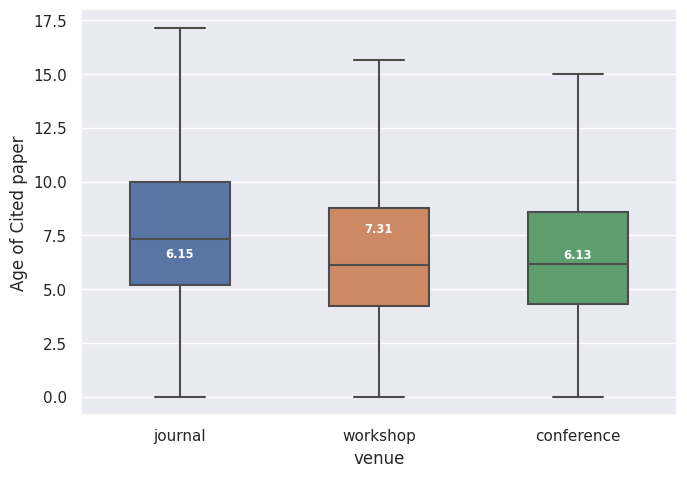

In [37]:
sns.set(rc={'figure.figsize':(7.7,5.27)})
# sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], hue=overall_df['venue'], width = 0.5, showfliers = False)
b = sns.boxplot(x= 'venue', y='Age of Cited paper', data = df_coarse_venue_age_overall, width = 0.5, showfliers = False)
# b = sns.violinplot(x= 'venue', y='Age of Cited paper', data = df_coarse_venue_age_overall, width = 0.5, showfliers = False)

# b.axes.set_title("Distribution of Mean Age of cited paper for differnt years for different venues ",fontsize=25)
# b.set_xlabel("Year of publication",fontsize=20)
# b.set_ylabel("Age of Cited paper",fontsize=20)
# b.tick_params(axis='both', which='major', labelsize=15)
# plt.legend(title='Venue', fontsize='15', title_fontsize='20')
# plt.show()
medians = df_coarse_venue_age_overall.groupby(['venue'])['Age of Cited paper'].median()
vertical_offset = df_coarse_venue_age_overall['Age of Cited paper'].median() * 0.05 # offset from median for display

for xtick in b.get_xticks():
    b.text(xtick, medians[xtick] + vertical_offset, str(round(medians[xtick],2)),
            horizontalalignment='center', size='x-small', color='w', weight='semibold')

In [38]:
b.get_xticks()

array([0, 1, 2])

In [39]:
medians = df_coarse_venue_age_overall.groupby(['venue'])['Age of Cited paper'].median()
print(medians)

venue
conference    6.150000
journal       7.312500
workshop      6.130435
Name: Age of Cited paper, dtype: float64


In [40]:
venue_age = dict()
for venue in unique_venues.keys():
  venue_age[venue] = dict()
  year2age  = dict()
  year2mean_age = dict()
  for paper_id in paper2ref.keys():
    if(paper_id not in dict_paper_id_to_venue.keys()):
      continue
    if(dict_paper_id_to_venue[paper_id] == venue):
      year, citation_age_list, mean_age = citation_age(paper_id)
      if(year != None):
        if(year not in year2age.keys()):
          year2age[year] = []
          year2mean_age[year] = []
        year2age[year].extend(citation_age_list)
        if(mean_age != None):
          year2mean_age[year].append(mean_age)
  venue_age[venue]["year2age"] = year2age
  venue_age[venue]["year2mean_age"] = year2mean_age

In [41]:
#overall venue distribution
coarse_venue_dist = dict()
for venue in ['journal', 'workshop', 'conference']:
  total = 0
  coarse_venue_dist[venue] = dict()
  for paper_id in paper2ref.keys():
    if(paper_id not in dict_paper_id_to_venue_coarse.keys()):
      continue
    if(dict_paper_id_to_venue_coarse[paper_id] == venue and paper_id in paper2year.keys()):
      year_published = paper2year[paper_id]
      reference_list = paper2ref[paper_id]
      for reference in reference_list:
        if(reference in paper_details.keys() and reference in paper2year.keys()):
          reference_year = paper2year[reference]
          age = year_published - reference_year
          total += 1
          if(age < 0 ):
            age = 0
          if(age > 30):
            continue
          if(age not in coarse_venue_dist[venue].keys()):
            coarse_venue_dist[venue][age] = 0
          coarse_venue_dist[venue][age] += 1
  for key, value in coarse_venue_dist[venue].items():
    coarse_venue_dist[venue][key] = (value/total)*100

In [42]:
coarse_venue_dist

{'journal': {3: 10.505105784897822,
  20: 0.8395626811278747,
  5: 7.6903941591313325,
  4: 9.134441970671277,
  2: 10.900633092451399,
  10: 3.2550156096468865,
  13: 2.109478973619075,
  8: 4.557270612818567,
  12: 2.522419433077526,
  1: 8.949116282540828,
  26: 0.44279157700966426,
  7: 5.497580815681787,
  6: 6.311023768952351,
  14: 1.9714175549447135,
  11: 2.8495379295762384,
  9: 3.806017487779699,
  15: 1.6393238721874652,
  21: 0.8432940708217764,
  17: 1.2835980547021728,
  19: 0.9564795582034602,
  27: 0.41045286632918315,
  25: 0.5398077090511076,
  24: 0.5186631674523315,
  28: 0.3880645281657732,
  16: 1.427878456199704,
  22: 0.7338399731339942,
  29: 0.32711849649871266,
  18: 1.0845906043607507,
  0: 3.5970596649212054,
  23: 0.6604559758205948,
  30: 0.28358561673652655},
 'workshop': {2: 12.801892907394038,
  3: 10.031039043849896,
  0: 7.512344475419081,
  4: 8.23456874700281,
  5: 6.706594084137415,
  11: 2.4259463219523507,
  10: 2.744768419222074,
  1: 14.33829

<ipython-input-43-e3ac5e9cbc9e>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)
<ipython-input-43-e3ac5e9cbc9e>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df3, ignore_index=True)
<ipython-input-43-e3ac5e9cbc9e>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df4, ignore_index=True)
<ipython-input-43-e3ac5e9cbc9e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-43-e3ac5e9cbc9e>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

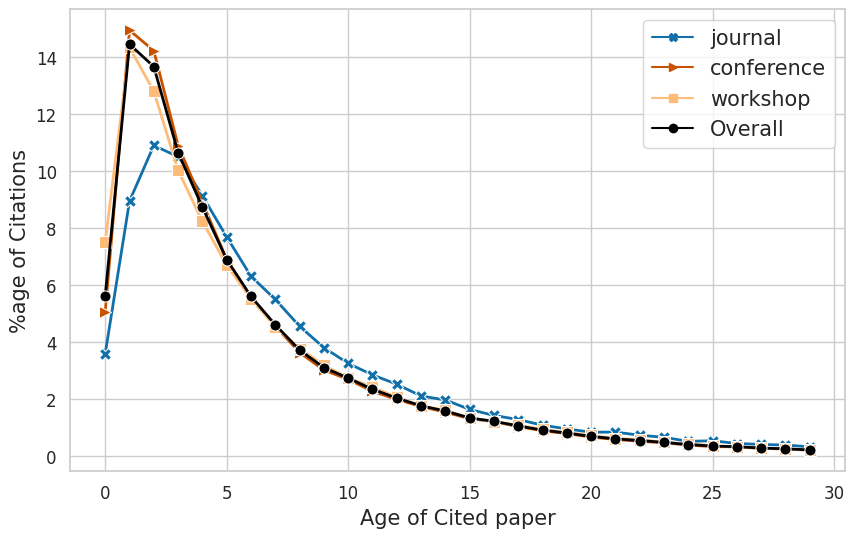

In [43]:

overall_df = pd.DataFrame()
for year in range(0, 30):
  dict1 = {'AoC': [coarse_venue_dist["journal"][year]], 'Type': ['journal'], 'Year of publication': [year]} 
  dict2 = {'AoC': [coarse_venue_dist["conference"][year]], 'Type': ['conference'], 'Year of publication': [year]} 
  dict3 = {'AoC': [coarse_venue_dist["workshop"][year]], 'Type': ['workshop'], 'Year of publication': [year]} 
  dict4 = {'AoC': [dict_aoc_overall[year]], 'Type': ['Overall'], 'Year of publication': [year]}

  df1 = pd.DataFrame(dict1)
  df2 = pd.DataFrame(dict2)
  df3 = pd.DataFrame(dict3)
  df4 = pd.DataFrame(dict4)

  df1 = df1.append(df2, ignore_index=True)
  df1 = df1.append(df3, ignore_index=True)
  df1 = df1.append(df4, ignore_index=True)
  overall_df = overall_df.append(df1, ignore_index=True)

# dict4 = {'AoC': [df_aoc], 'Type': ['Overall'], 'Year of publication': [year]}
# df4 = pd.DataFrame(dict4)
# overall_df = overall_df.append(df4, ignore_index=True)

sns.set(font_scale = 8)
sns.set(rc={'figure.figsize':(10,6)})
# b = sns.lineplot(data = overall_df, x='Year of publication', y='AoC', hue='Type', marker="o")
sns.set_style(style='whitegrid')
b = sns.lineplot(data = overall_df, x='Year of publication', y='AoC', hue='Type', palette=['#1170aa', '#c85200', '#ffbc79', 'black'], style='Type', dashes = False, markers=['X', '>', 's', 'o'], linewidth=2, markersize=8 )

b.set_xlabel("Age of Cited paper",fontsize=15)
b.set_ylabel("%age of Citations",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right", frameon=True, fontsize=15)
plt.show()

In [44]:
import statistics 
dict_citation_dist = dict()
dict_citation_dist["0"] = []
dict_citation_dist["1-9"] = []
dict_citation_dist["10-49"] = []
dict_citation_dist["50-99"] = []
dict_citation_dist["100-499"] = []
dict_citation_dist["500-999"] = []
dict_citation_dist["1000-1999"] = []
dict_citation_dist["2000-4999"] = []
dict_citation_dist["5000+"] = []

dict_paperid_citationidef = dict()
for paper_id in tqdm.tqdm(paper2ref.keys()):
  if(paper_id in dict_paperid_citationCount.keys()):
    count_citation = dict_paperid_citationCount[paper_id]
    identifier_bucket = ""
    if(count_citation == 0):
      identifier_bucket = "0"
    elif(count_citation >= 1 and count_citation <= 9):
      identifier_bucket = "1-9"
    elif(count_citation >= 10 and count_citation <= 49):
      identifier_bucket = "10-49"
    elif(count_citation >= 50 and count_citation <= 99):
      identifier_bucket = "50-99"
    elif(count_citation >= 100 and count_citation <= 499):
      identifier_bucket = "100-499"
    elif(count_citation >= 500 and count_citation <= 999):
      identifier_bucket = "500-999"
    elif(count_citation >= 1000 and count_citation <= 1999):
      identifier_bucket = "1000-1999"
    elif(count_citation >= 2000 and count_citation <= 4999):
      identifier_bucket = "2000-4999"
    elif(count_citation >= 5000):
      identifier_bucket = "5000+"
    
    dict_citation_dist[identifier_bucket].append(paper_id)
    dict_paperid_citationidef[paper_id] = identifier_bucket

aoc_citation_dist = dict()
for idef in dict_citation_dist.keys():
  aoc_citation_dist[idef] = dict()
  for year in range(0, 31):
    aoc_citation_dist[idef][year] = 0

for paper_id in tqdm.tqdm(paper2ref.keys()):
  if(paper_id in paper2year.keys()):
    year_published = paper2year[paper_id]
    reference_list = paper2ref[paper_id]
    # print(reference_list)
    for reference in reference_list:
      if(reference in paper_details.keys() and reference in paper2year.keys() and reference in paper2ref.keys() and reference in dict_paperid_citationidef.keys()):
        # print(reference)
        reference_year = paper2year[reference]
        age = year_published - reference_year
        if(age < 0 ):
          age = 0
        if(age > 30):
          continue

        idef_for_reference_paper = dict_paperid_citationidef[reference]
        if(idef_for_reference_paper != '0'):
          aoc_citation_dist[idef_for_reference_paper][age] += 1

        # if(reference in dict_citation_dist['0']):
        #   print(f'Something is wrong with paper {reference} ')
  
# for idef in aoc_citation_dist.keys():
#   total = 0
#   for x in aoc_citation_dist[idef].keys():
#     total += aoc_citation_dist[idef][x]

#   for key, value in aoc_citation_dist[idef].items():
#     if(total <= 0):
#       aoc_citation_dist[idef][key] = 0
#     else:
#       aoc_citation_dist[idef][key] = (value/total)*100
  

# distribution of AoC based on the citation count
# aoc_citation_dist = dict()
# for citation_bucket_identifier in dict_citation_dist.keys():
#   total = 0
#   aoc_citation_dist[citation_bucket_identifier] = dict()
#   for paper_id in paper2ref.keys():
#     if(paper_id not in dict_paperid_citation_count.keys()):
#       continue
#     if(dict_paperid_citation_count[paper_id] == citation_bucket_identifier and paper_id in paper2year.keys()):
#       year_published = paper2year[paper_id]
#       reference_list = paper2ref[paper_id]
#       for reference in reference_list:
#         if(reference in paper_details.keys() and reference in paper2year.keys()):
#           reference_year = paper2year[reference]
#           age = year_published - reference_year
#           total += 1
#           if(age < 0 ):
#             age = 0
#           if(age > 30):
#             continue
#           if(age not in aoc_citation_dist[citation_bucket_identifier].keys()):
#             aoc_citation_dist[citation_bucket_identifier][age] = 0
#           aoc_citation_dist[citation_bucket_identifier][age] += 1
#   for key, value in aoc_citation_dist[citation_bucket_identifier].items():
#     aoc_citation_dist[citation_bucket_identifier][key] = (value/total)*100

  

100%|██████████| 73744/73744 [00:02<00:00, 31329.50it/s]


In [45]:
aoc_citation_dist

{'0': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 0},
 '1-9': {0: 6217,
  1: 9281,
  2: 5561,
  3: 2731,
  4: 1984,
  5: 1143,
  6: 918,
  7: 588,
  8: 428,
  9: 297,
  10: 232,
  11: 178,
  12: 142,
  13: 121,
  14: 83,
  15: 56,
  16: 58,
  17: 32,
  18: 46,
  19: 34,
  20: 21,
  21: 22,
  22: 23,
  23: 10,
  24: 15,
  25: 20,
  26: 13,
  27: 10,
  28: 10,
  29: 4,
  30: 3},
 '10-49': {0: 13553,
  1: 34938,
  2: 25667,
  3: 15776,
  4: 11193,
  5: 7565,
  6: 5828,
  7: 4166,
  8: 3438,
  9: 2266,
  10: 1695,
  11: 1314,
  12: 1023,
  13: 719,
  14: 637,
  15: 446,
  16: 340,
  17: 307,
  18: 235,
  19: 178,
  20: 153,
  21: 141,
  22: 136,
  23: 83,
  24: 59,
  25: 51,
  26: 49,
  27: 35,
  28: 40,
  29: 37,
  30: 24},
 '50-99': {0: 6408,
  1: 20166,
  2: 17324,
  3:

<ipython-input-46-62f1cd7991a0>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)
<ipython-input-46-62f1cd7991a0>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df3, ignore_index=True)
<ipython-input-46-62f1cd7991a0>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df4, ignore_index=True)
<ipython-input-46-62f1cd7991a0>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df5, ignore_index=True)
<ipython-input-46-62f1cd7991a0>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

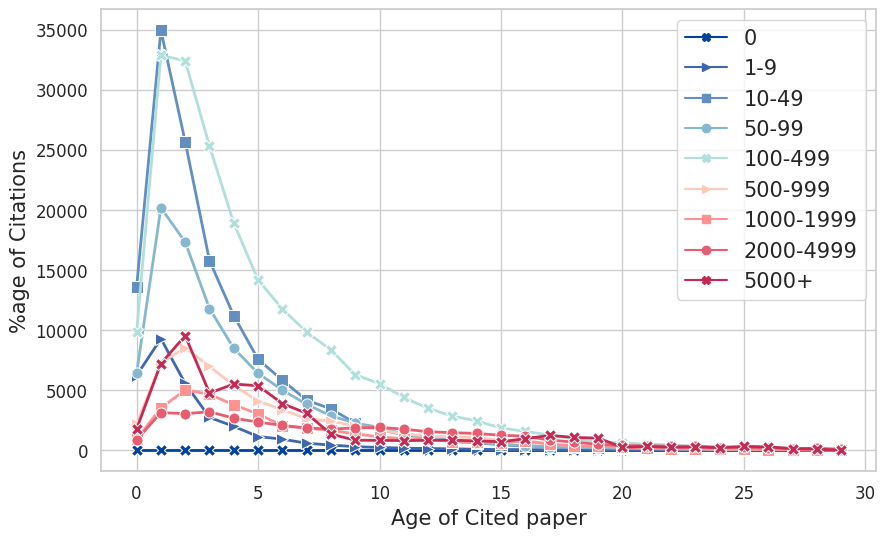

In [46]:

overall_df = pd.DataFrame()
for year in range(0, 30):
  dict1 = {'AoC': [aoc_citation_dist["0"][year]], 'Type': ['0'], 'Year of publication': [year]} 
  dict2 = {'AoC': [aoc_citation_dist["1-9"][year]], 'Type': ['1-9'], 'Year of publication': [year]} 
  dict3 = {'AoC': [aoc_citation_dist["10-49"][year]], 'Type': ['10-49'], 'Year of publication': [year]} 
  dict4 = {'AoC': [aoc_citation_dist["50-99"][year]], 'Type': ['50-99'], 'Year of publication': [year]} 
  dict5 = {'AoC': [aoc_citation_dist["100-499"][year]], 'Type': ['100-499'], 'Year of publication': [year]} 
  dict6 = {'AoC': [aoc_citation_dist["500-999"][year]], 'Type': ['500-999'], 'Year of publication': [year]} 
  dict7 = {'AoC': [aoc_citation_dist["1000-1999"][year]], 'Type': ['1000-1999'], 'Year of publication': [year]} 
  dict8 = {'AoC': [aoc_citation_dist["2000-4999"][year]], 'Type': ['2000-4999'], 'Year of publication': [year]} 
  dict9 = {'AoC': [aoc_citation_dist["5000+"][year]], 'Type': ['5000+'], 'Year of publication': [year]} 

  df1 = pd.DataFrame(dict1)
  df2 = pd.DataFrame(dict2)
  df3 = pd.DataFrame(dict3)
  df4 = pd.DataFrame(dict4)
  df5 = pd.DataFrame(dict5)
  df6 = pd.DataFrame(dict6)
  df7 = pd.DataFrame(dict7)
  df8 = pd.DataFrame(dict8)
  df9 = pd.DataFrame(dict9)

  df1 = df1.append(df2, ignore_index=True)
  df1 = df1.append(df3, ignore_index=True)
  df1 = df1.append(df4, ignore_index=True)
  df1 = df1.append(df5, ignore_index=True)
  df1 = df1.append(df6, ignore_index=True)
  df1 = df1.append(df7, ignore_index=True)
  df1 = df1.append(df8, ignore_index=True)
  df1 = df1.append(df9, ignore_index=True)

  overall_df = overall_df.append(df1, ignore_index=True)

# dict4 = {'AoC': [df_aoc], 'Type': ['Overall'], 'Year of publication': [year]}
# df4 = pd.DataFrame(dict4)
# overall_df = overall_df.append(df4, ignore_index=True)

sns.set(font_scale = 8)
sns.set(rc={'figure.figsize':(10,6)})
# b = sns.lineplot(data = overall_df, x='Year of publication', y='AoC', hue='Type', marker="o")
sns.set_style(style='whitegrid')
b = sns.lineplot(data = overall_df, x='Year of publication', y='AoC', hue='Type', palette=['#00429d', '#3e67ae', '#618fbf', '#85b7ce', '#b1dfdb', '#ffcab9', '#fd9291', '#e75d6f', '#c52a52', '#93003a'], style='Type', dashes = False, markers=['X', '>', 's', 'o'], linewidth=2, markersize=8 )

b.set_xlabel("Age of Cited paper",fontsize=15)
b.set_ylabel("%age of Citations",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right", frameon=True, fontsize=15)
plt.show()

In [47]:
aoc_citation_dist

{'0': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 0},
 '1-9': {0: 6217,
  1: 9281,
  2: 5561,
  3: 2731,
  4: 1984,
  5: 1143,
  6: 918,
  7: 588,
  8: 428,
  9: 297,
  10: 232,
  11: 178,
  12: 142,
  13: 121,
  14: 83,
  15: 56,
  16: 58,
  17: 32,
  18: 46,
  19: 34,
  20: 21,
  21: 22,
  22: 23,
  23: 10,
  24: 15,
  25: 20,
  26: 13,
  27: 10,
  28: 10,
  29: 4,
  30: 3},
 '10-49': {0: 13553,
  1: 34938,
  2: 25667,
  3: 15776,
  4: 11193,
  5: 7565,
  6: 5828,
  7: 4166,
  8: 3438,
  9: 2266,
  10: 1695,
  11: 1314,
  12: 1023,
  13: 719,
  14: 637,
  15: 446,
  16: 340,
  17: 307,
  18: 235,
  19: 178,
  20: 153,
  21: 141,
  22: 136,
  23: 83,
  24: 59,
  25: 51,
  26: 49,
  27: 35,
  28: 40,
  29: 37,
  30: 24},
 '50-99': {0: 6408,
  1: 20166,
  2: 17324,
  3:

In [48]:
for key, value in dict_citation_dist.items():
  print(f'For {key} number of papers = {len(value)} ')

For 0 number of papers = 8715 
For 1-9 number of papers = 29260 
For 10-49 number of papers = 22501 
For 50-99 number of papers = 4937 
For 100-499 number of papers = 3939 
For 500-999 number of papers = 346 
For 1000-1999 number of papers = 132 
For 2000-4999 number of papers = 81 
For 5000+ number of papers = 59 


In [49]:
# mean mAoC for overall, journal, conference and workshop

total = 0
count = 0
dict_aoc_overall = dict() #stores key: age of citation, value: no. of references having that AoC
for paper_id in tqdm.tqdm(paper2ref.keys()):
  if(paper_id in paper2year.keys()):
    year_published = paper2year[paper_id]
    reference_list = paper2ref[paper_id]
    for reference in reference_list:
      if(reference in paper_details.keys() and reference in paper2year.keys()):
        reference_year = paper2year[reference]
        age = year_published - reference_year
        total += 1
        # if(age > 20):
        #   print(f'Year published = {year_published} --- reference_year {reference_year}')
        if(age < 0 ):
          age = 0
        if(age > 30):
          continue
        total += age
        count += 1

print(f'Mean mAoC for ALL the papers = {total/count} ')

for venue in ['journal', 'workshop', 'conference']:
  total = 0
  count = 0
  for paper_id in paper2ref.keys():
    if(paper_id not in dict_paper_id_to_venue_coarse.keys()):
      continue
    if(dict_paper_id_to_venue_coarse[paper_id] == venue and paper_id in paper2year.keys()):
      year_published = paper2year[paper_id]
      reference_list = paper2ref[paper_id]
      for reference in reference_list:
        if(reference in paper_details.keys() and reference in paper2year.keys()):
          reference_year = paper2year[reference]
          age = year_published - reference_year
          total += 1
          # if(age > 20):
          #   print(f'Year published = {year_published} --- reference_year {reference_year}')
          if(age < 0 ):
            age = 0
          if(age > 30):
            continue
          total += age
          count += 1
      
  print(f'Mean mAoC for {venue} the papers = {total/count} ')

100%|██████████| 73744/73744 [00:01<00:00, 42266.84it/s]


Mean mAoC for ALL the papers = 7.023020093533347 
Mean mAoC for journal the papers = 8.160376625395017 
Mean mAoC for workshop the papers = 7.01574813830148 
Mean mAoC for conference the papers = 6.93442281756273 


In [50]:
# Mean, median and mode of each venue OVERALL
dict_count_reference_venue = dict()
for venue in ['journal', 'workshop', 'conference']:
  temp_list = []
  for paper_id in paper2ref.keys():
    if(paper_id not in dict_paper_id_to_venue_coarse.keys()):
      continue
    if(dict_paper_id_to_venue_coarse[paper_id] == venue and paper_id in paper2year.keys()):
      year_published = paper2year[paper_id]
      reference_list = paper2ref[paper_id]
      count_ref = len(reference_list)
      temp_list.append(count_ref)
  dict_count_reference_venue[venue] = temp_list
  print(f'Venue. =  {venue} ')
  print(f'Mean number of references for ALL the papers = {statistics.mean(temp_list)} ')
  print(f'Median number of references for ALL the papers = {statistics.median(temp_list)} ')
  print(f'Mode number of references for ALL the papers = {statistics.mode(temp_list)} ')
  print()

print(f'Overall')
print(f'Mean number of references for ALL the papers = {statistics.mean(list_number_of_ref)} ')
print(f'Median number of references for ALL the papers = {statistics.median(list_number_of_ref)} ')
print(f'Mode number of references for ALL the papers = {statistics.mode(list_number_of_ref)} ')

Venue. =  journal 
Mean number of references for ALL the papers = 23.2406372275014 
Median number of references for ALL the papers = 15.0 
Mode number of references for ALL the papers = 1 

Venue. =  workshop 
Mean number of references for ALL the papers = 19.073527240513805 
Median number of references for ALL the papers = 17 
Mode number of references for ALL the papers = 1 

Venue. =  conference 
Mean number of references for ALL the papers = 21.114755814196897 
Median number of references for ALL the papers = 19 
Mode number of references for ALL the papers = 1 

Overall
Mean number of references for ALL the papers = 20.638831633760034 
Median number of references for ALL the papers = 18.0 
Mode number of references for ALL the papers = 1 


In [51]:
#question 4 for venues
dict_count_reference_year_venue = dict()
for venue in ['journal', 'workshop', 'conference']:
  temp_dict = dict()
  for paper_id in paper2ref.keys():
    if(paper_id not in dict_paper_id_to_venue_coarse.keys()):
      continue
    if(dict_paper_id_to_venue_coarse[paper_id] == venue and paper_id in paper2year.keys()):
      year_published = paper2year[paper_id]
      reference_list = paper2ref[paper_id]
      count_ref = len(reference_list)
      if(year_published not in temp_dict.keys()):
        temp_dict[year_published] = []
      temp_dict[year_published].append(count_ref)
  dict_count_reference_year_venue[venue] = dict()
  for year, list_count_ref in temp_dict.items():
    avg_year = sum(list_count_ref)/len(list_count_ref)
    dict_count_reference_year_venue[venue][year] = avg_year

In [52]:
dict_count_reference_year_venue

{'journal': {2021: 37.274809160305345,
  2020: 32.40609137055838,
  2017: 36.895161290322584,
  2019: 37.065693430656935,
  2018: 47.604395604395606,
  2016: 44.41975308641975,
  2015: 31.0431654676259,
  2011: 22.83809523809524,
  2014: 41.51578947368421,
  2007: 18.468503937007874,
  2013: 33.02919708029197,
  2012: 32.78181818181818,
  2006: 21.455696202531644,
  2010: 27.74074074074074,
  2009: 25.30851063829787,
  2008: 33.851851851851855,
  2005: 24.32758620689655,
  2004: 33.3125,
  2003: 30.95744680851064,
  2000: 18.857142857142858,
  2002: 27.114285714285714,
  2001: 14.553191489361701,
  1995: 13.641509433962264,
  1998: 15.777777777777779,
  1999: 15.857142857142858,
  1997: 16.819444444444443,
  1996: 16.836363636363636,
  1989: 7.6923076923076925,
  1990: 6.533333333333333,
  1994: 12.10126582278481,
  1993: 15.89795918367347,
  1987: 10.387096774193548,
  1992: 11.783333333333333,
  1991: 14.666666666666666,
  1988: 9.833333333333334,
  1986: 6.660377358490566,
  1985: 1

<ipython-input-53-6bbfeafafd70>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)
<ipython-input-53-6bbfeafafd70>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df3, ignore_index=True)
<ipython-input-53-6bbfeafafd70>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df4, ignore_index=True)
<ipython-input-53-6bbfeafafd70>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-53-6bbfeafafd70>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

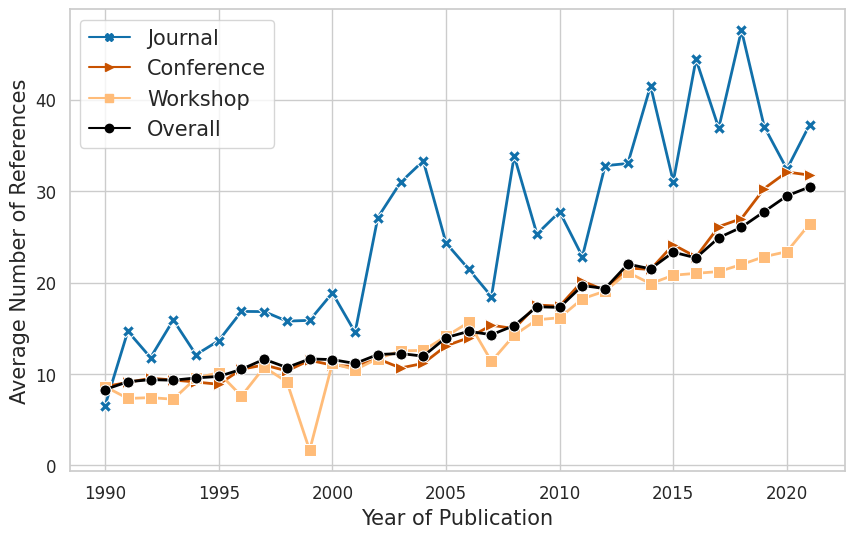

In [53]:

overall_df = pd.DataFrame()
for year in range(1990, 2022):
  dict1 = {'AoC': [dict_count_reference_year_venue["journal"][year]], 'Type': ['Journal'], 'Year of publication': [year]} 
  dict2 = {'AoC': [dict_count_reference_year_venue["conference"][year]], 'Type': ['Conference'], 'Year of publication': [year]} 
  dict3 = {'AoC': [dict_count_reference_year_venue["workshop"][year]], 'Type': ['Workshop'], 'Year of publication': [year]} 
  dict4 = {'AoC': [dict_avg_reference_year[year]], 'Type': ['Overall'], 'Year of publication': [year]}

  df1 = pd.DataFrame(dict1)
  df2 = pd.DataFrame(dict2)
  df3 = pd.DataFrame(dict3)
  df4 = pd.DataFrame(dict4)

  df1 = df1.append(df2, ignore_index=True)
  df1 = df1.append(df3, ignore_index=True)
  df1 = df1.append(df4, ignore_index=True)
  overall_df = overall_df.append(df1, ignore_index=True)

# dict4 = {'AoC': [df_aoc], 'Type': ['Overall'], 'Year of publication': [year]}
# df4 = pd.DataFrame(dict4)
# overall_df = overall_df.append(df4, ignore_index=True)

sns.set(font_scale = 8)
sns.set(rc={'figure.figsize':(10,6)})
# b = sns.lineplot(data = overall_df, x='Year of publication', y='AoC', hue='Type', marker="o")
sns.set_style(style='whitegrid')
b = sns.lineplot(data = overall_df, x='Year of publication', y='AoC', hue='Type', palette=['#1170aa', '#c85200', '#ffbc79', 'black'], style='Type', dashes = False, markers=['X', '>', 's', 'o'], linewidth=2, markersize=8 )

b.set_xlabel("Year of Publication",fontsize=15)
b.set_ylabel("Average Number of References",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper left", frameon=True, fontsize=15)
plt.show()

In [55]:
sns.lineplot(data = overall_df, x='Year of publication', y='AoC', hue='type')

ValueError: ignored

In [56]:
def plot(data='year2age'):
  overall_df = []
  for year in range(1991, 2022):
    journal_list = ['journal' for x in range(len(coarse_venue_age["journal"][data][year]))]
    workshop_list = ['workshop' for x in range(len(coarse_venue_age["workshop"][data][year]))]
    conference_list = ['conference' for x in range(len(coarse_venue_age["conference"][data][year]))]

    dict1 = {'Age of Cited paper': coarse_venue_age["journal"][data][year], 'venue': journal_list, 'Year of publication': year} 
    dict2 = {'Age of Cited paper': coarse_venue_age["workshop"][data][year], 'venue': workshop_list, 'Year of publication': year} 
    dict3 = {'Age of Cited paper': coarse_venue_age["conference"][data][year], 'venue': conference_list, 'Year of publication': year} 

    df1 = pd.DataFrame(dict1)
    df2 = pd.DataFrame(dict2)
    df3 = pd.DataFrame(dict3)
    frames = [df1, df2, df3]

    df = pd.concat(frames)
    overall_df.append(df)
  overall_df = pd.concat(overall_df)
  sns.set(rc={'figure.figsize':(40,10)})
  sns.set_style(style='whitegrid')
  plt.ylim(-2, 25)
  
  # sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], hue=overall_df['venue'], width = 0.5, showfliers = False)
  
  # b = sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], hue=overall_df['venue'], width = 0.5, showfliers = False)
  b = sns.violinplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], hue=overall_df['venue'], width = 0.7, cut=0, showfliers = False)
  # inner="box", palette="Set3", cut=2, linewidth=2
  # b.axes.set_title("Distribution of Mean Age of cited paper for differnt years for different venues ",fontsize=25)
  b.set_xlabel("Year of publication",fontsize=25)
  b.set_ylabel("mean Age of Citations $\mathit{(mAoC)}$ ",fontsize=25)
  b.tick_params(axis='x', rotation=30)
  b.tick_params(axis='both', which='major', labelsize=20)
  # plt.legend(title='Venue', fontsize='15', title_fontsize='20')
  plt.legend(loc="upper left", frameon=True, fontsize=20)
  plt.show()


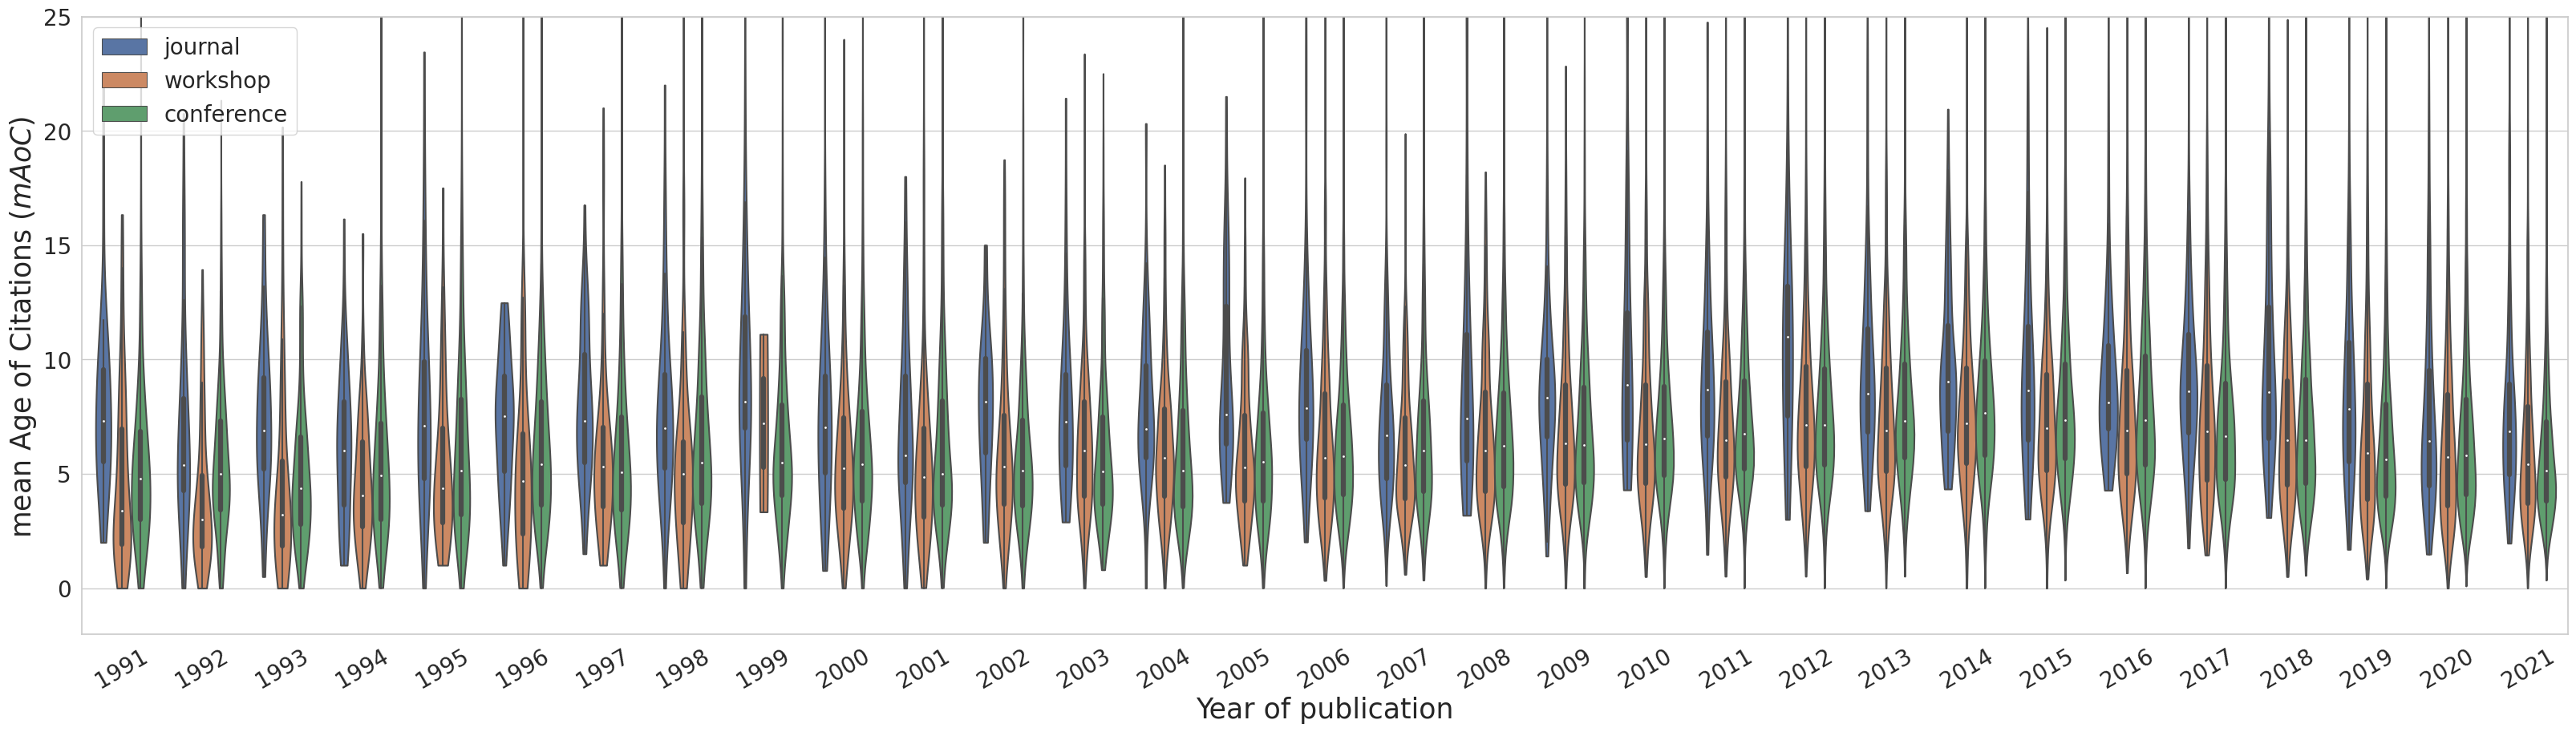

In [57]:
plot("year2mean_age")

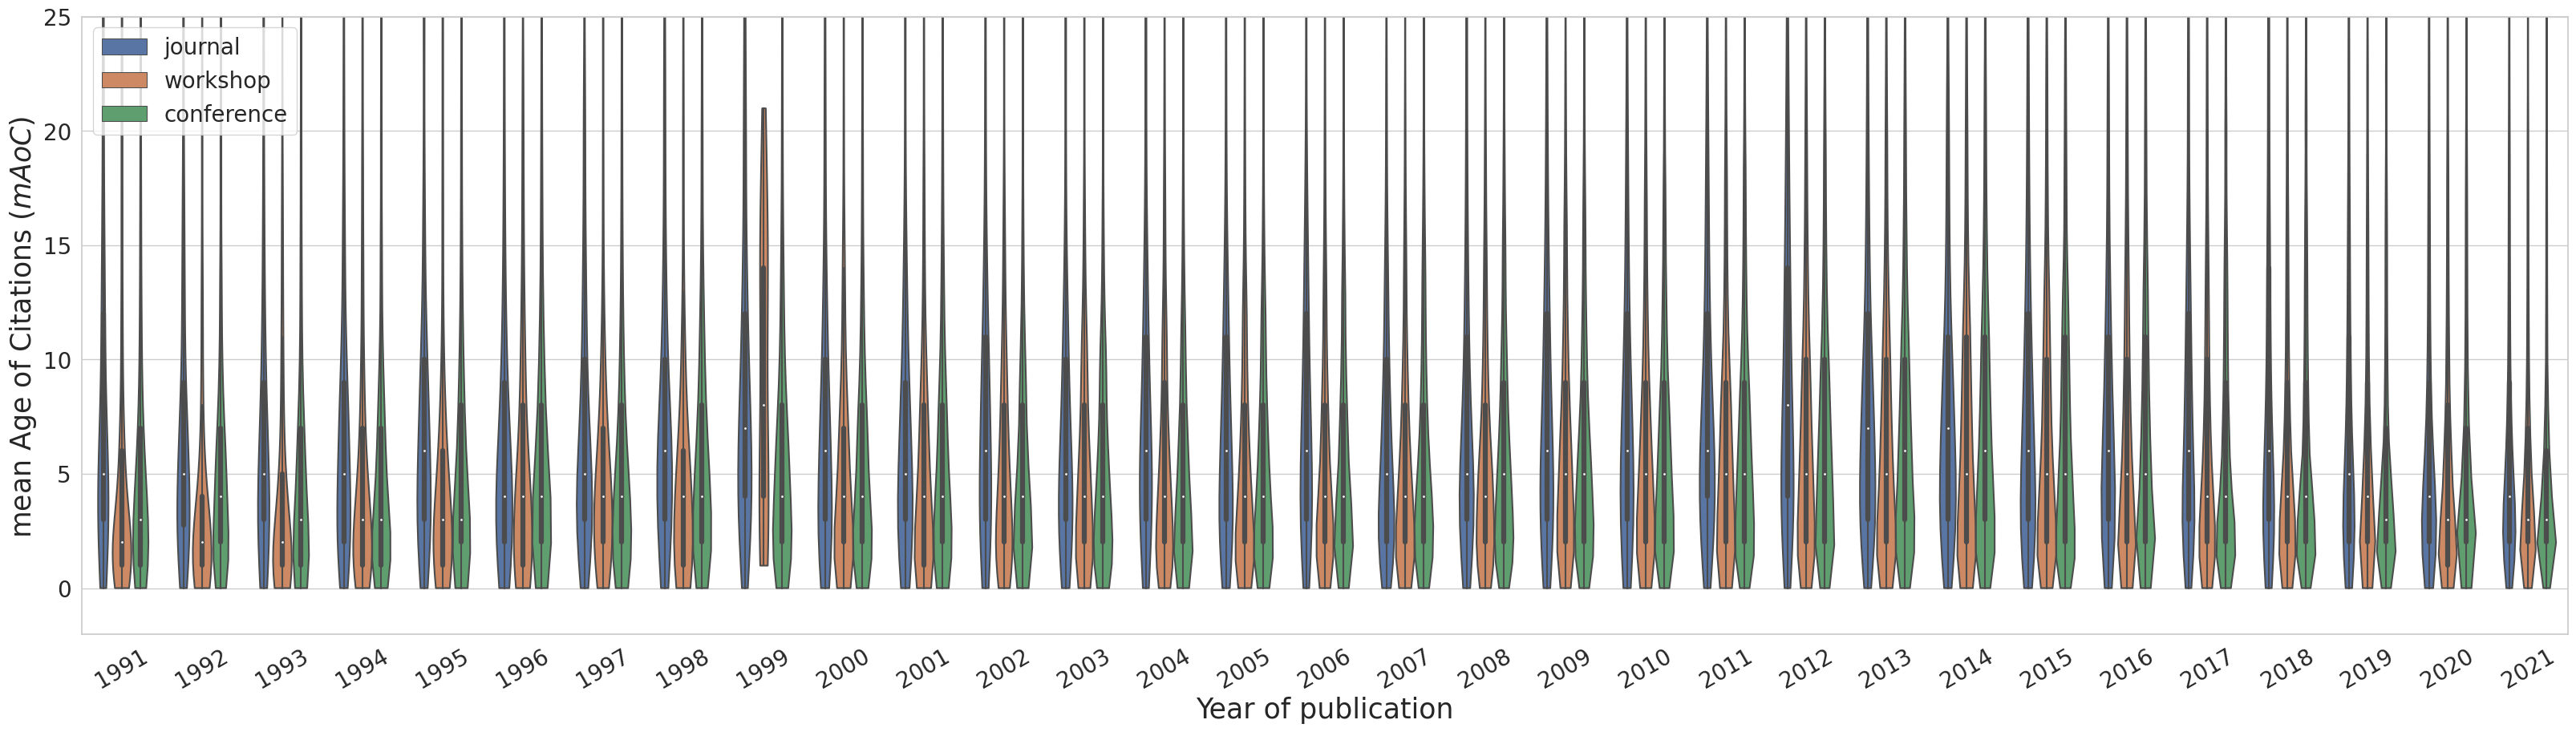

In [58]:
plot()

In [70]:
#plot mean for each year
overall_df = pd.DataFrame()
for year in range(1990, 2022):
  dict1 = {'Mean Age of Cited paper': [sum(year2age[year]) / len(year2age[year])], 'type': ['Complete'], 'Year of publication': [year]} 
  dict2 = {'Mean Age of Cited paper': [sum(year2mean_age[year]) / len(year2mean_age[year])], 'type': ['Mean'], 'Year of publication': [year]} 

  df1 = pd.DataFrame(dict1)
  df2 = pd.DataFrame(dict2)
  df1 = df1.append(df2, ignore_index=True)
  overall_df = overall_df.append(df1, ignore_index=True)

sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(20.7,7.27)})
# sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], width = 0.2, showfliers = False)

# b = sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], width = 0.2, showfliers = False)
b = sns.lineplot(data = overall_df, x='Year of publication', y='Mean Age of Cited paper', hue='type')
# b.set(xticks=df.Date.values)
b.axes.set_title("Trend of Mean Age of cited paper for differnt years ",fontsize=20)
b.set_xlabel("Year of publication",fontsize=15)
b.set_ylabel("Age of Cited paper",fontsize=15)
b.tick_params(axis='both', which='all', labelsize=10)
plt.xticks(range(1990, 2022))
plt.show()

KeyError: ignored

In [71]:
def plot_mean(data='year2age'):
  overall_df = pd.DataFrame()
  for year in range(1991, 2022):
    journal_list = ['journal' for x in range(len(coarse_venue_age["journal"][data][year]))]
    workshop_list = ['workshop' for x in range(len(coarse_venue_age["workshop"][data][year]))]
    conference_list = ['conference' for x in range(len(coarse_venue_age["conference"][data][year]))]

    dict1 = {'Mean Age of Cited paper': [sum(coarse_venue_age["journal"][data][year])/len(coarse_venue_age["journal"][data][year])], 'venue': ['journal'], 'Year of publication': [year]} 
    dict2 = {'Mean Age of Cited paper': [sum(coarse_venue_age["workshop"][data][year])/len(coarse_venue_age["workshop"][data][year])], 'venue': ['workshop'], 'Year of publication': [year]} 
    dict3 = {'Mean Age of Cited paper': [sum(coarse_venue_age["conference"][data][year])/len(coarse_venue_age["conference"][data][year])], 'venue': ['conference'], 'Year of publication': [year]} 

    df1 = pd.DataFrame(dict1)
    df2 = pd.DataFrame(dict2)
    df3 = pd.DataFrame(dict3)


    df1 = df1.append(df2, ignore_index=True)
    df1 = df1.append(df3, ignore_index=True)

    overall_df = overall_df.append(df1, ignore_index=True)
    # frames = [df1, df2, df3]

    # df = pd.concat(frames)
    # overall_df.append(df)
  # overall_df = pd.concat(overall_df)
  sns.set(rc={'figure.figsize':(35.7,10.27)})
  # sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], hue=overall_df['venue'], width = 0.5, showfliers = False)
  
  # b = sns.boxplot(x= overall_df['Year of publication'], y=overall_df['Age of Cited paper'], hue=overall_df['venue'], width = 0.5, showfliers = False)
  b = sns.lineplot(data = overall_df, x='Year of publication', y='Mean Age of Cited paper', hue='venue')
  b.axes.set_title("Trend of Mean of Mean Age of cited paper for differnt years for different venues ",fontsize=25)
  b.set_xlabel("Year of publication",fontsize=20)
  b.set_ylabel("Age of Cited paper",fontsize=20)
  b.tick_params(axis='both', which='major', labelsize=15)
  plt.legend(title='Venue', fontsize='15', title_fontsize='20')
  plt.xticks(range(1991, 2022))
  plt.show()
  return overall_df



<ipython-input-71-eded61b56463>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)
<ipython-input-71-eded61b56463>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df3, ignore_index=True)
<ipython-input-71-eded61b56463>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-71-eded61b56463>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)
<ipython-input-71-eded61b56463>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

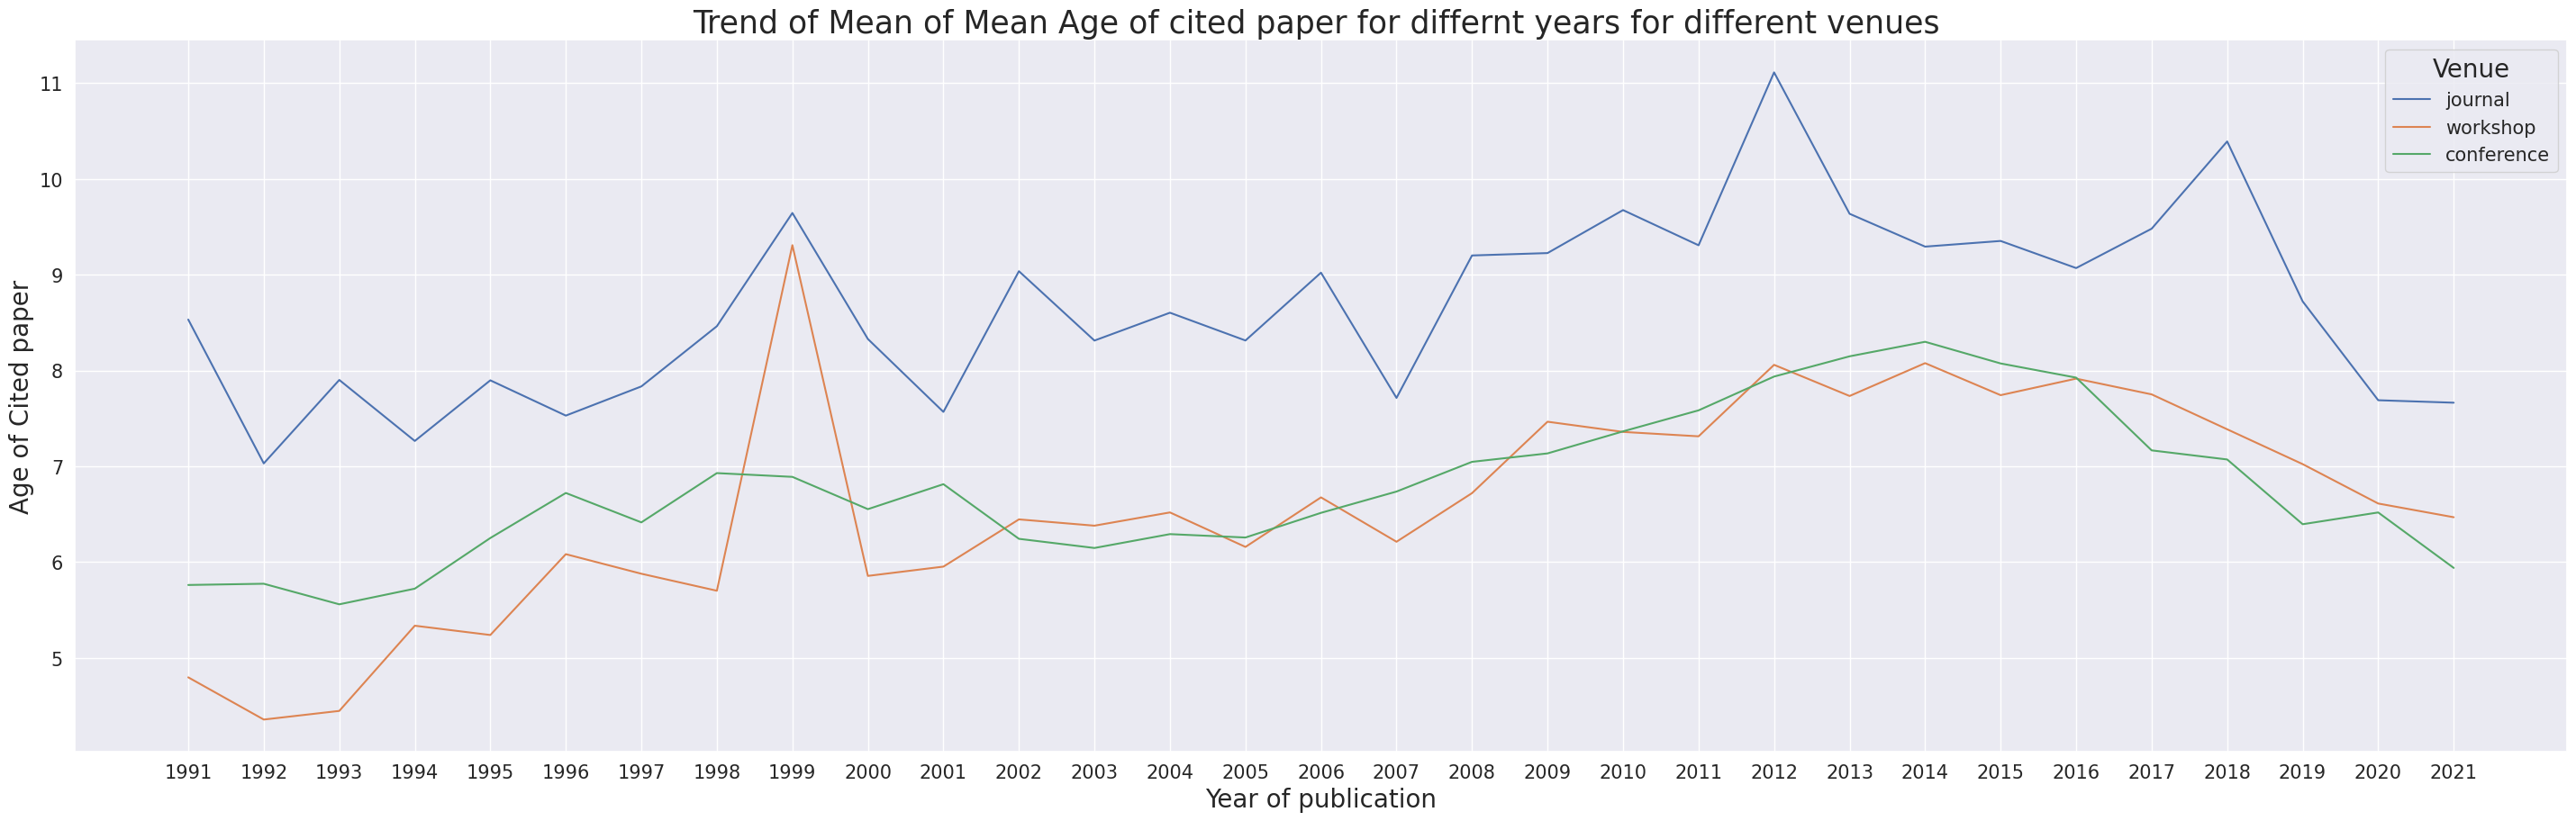

In [72]:
overall_df = plot_mean()

In [73]:
print(overall_df.to_string())

    Mean Age of Cited paper       venue  Year of publication
0                  8.531142     journal                 1991
1                  4.796992    workshop                 1991
2                  5.760924  conference                 1991
3                  7.029940     journal                 1992
4                  4.356463    workshop                 1992
5                  5.773892  conference                 1992
6                  7.900826     journal                 1993
7                  4.446629    workshop                 1993
8                  5.559131  conference                 1993
9                  7.264088     journal                 1994
10                 5.335890    workshop                 1994
11                 5.722540  conference                 1994
12                 7.896907     journal                 1995
13                 5.238901    workshop                 1995
14                 6.251131  conference                 1995
15                 7.528

<ipython-input-71-eded61b56463>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)
<ipython-input-71-eded61b56463>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df3, ignore_index=True)
<ipython-input-71-eded61b56463>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-71-eded61b56463>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)
<ipython-input-71-eded61b56463>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

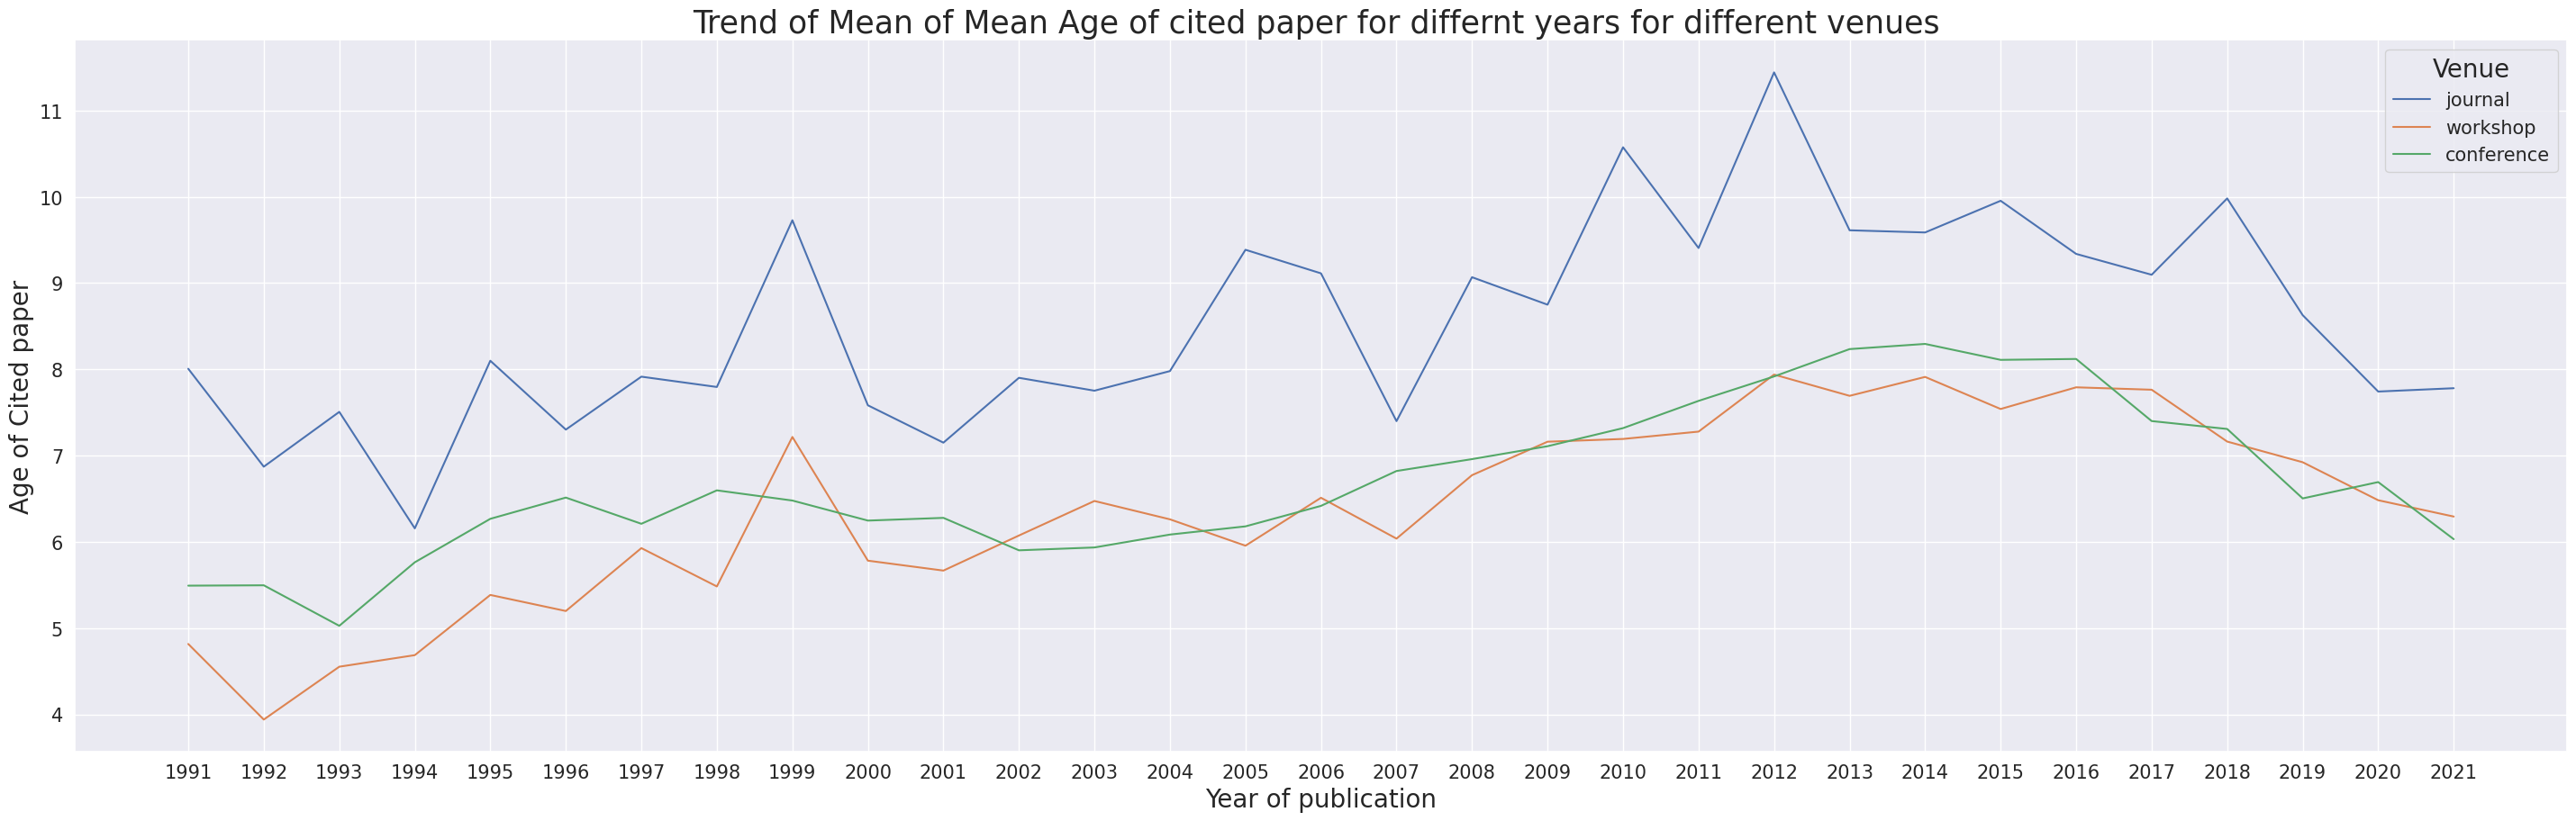

Mean Age of Cited paper       venue  Year of publication
0                  8.007285     journal                 1991
1                  4.816745    workshop                 1991
2                  5.492769  conference                 1991
3                  6.871952     journal                 1992
4                  3.940568    workshop                 1992
..                      ...         ...                  ...
88                 6.483033    workshop                 2020
89                 6.693438  conference                 2020
90                 7.781594     journal                 2021
91                 6.293807    workshop                 2021
92                 6.031763  conference                 2021

[93 rows x 3 columns]

In [74]:
plot_mean('year2mean_age')

<ipython-input-75-41332be273ad>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)
<ipython-input-75-41332be273ad>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df3, ignore_index=True)
<ipython-input-75-41332be273ad>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-75-41332be273ad>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)
<ipython-input-75-41332be273ad>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

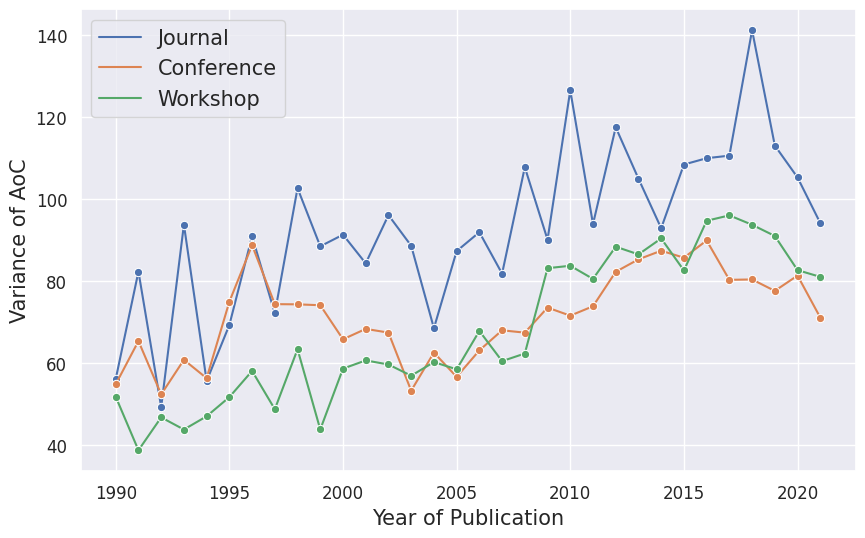

In [75]:
year_venue_variance = dict()
for venue in ['journal', 'workshop', 'conference']:
  year_venue_variance[venue] = dict()
  for year in range(1990, 2022):
    if(len(coarse_venue_age[venue]['year2age'][year]) <= 1):
      var = 0
    else:
      # print(f'Year =  {year} ::  count = {len(year2age[year])} ')
      # var = stdev(coarse_venue_age[venue]['year2age'][year])
      var = variance(coarse_venue_age[venue]['year2age'][year])
      # var = variance(year2age[year])
    year_venue_variance[venue][year] = var
  

overall_df = pd.DataFrame()
for year in range(1990, 2022):
  dict1 = {'AoC': [year_venue_variance["journal"][year]], 'Type': ['Journal'], 'Year of publication': [year]} 
  dict2 = {'AoC': [year_venue_variance["conference"][year]], 'Type': ['Conference'], 'Year of publication': [year]} 
  dict3 = {'AoC': [year_venue_variance["workshop"][year]], 'Type': ['Workshop'], 'Year of publication': [year]} 
  # dict4 = {'AoC': [dict_avg_reference_year[year]], 'Type': ['Overall'], 'Year of publication': [year]}

  df1 = pd.DataFrame(dict1)
  df2 = pd.DataFrame(dict2)
  df3 = pd.DataFrame(dict3)
  # df4 = pd.DataFrame(dict4)

  df1 = df1.append(df2, ignore_index=True)
  df1 = df1.append(df3, ignore_index=True)
  # df1 = df1.append(df4, ignore_index=True)
  overall_df = overall_df.append(df1, ignore_index=True)

# dict4 = {'AoC': [df_aoc], 'Type': ['Overall'], 'Year of publication': [year]}
# df4 = pd.DataFrame(dict4)
# overall_df = overall_df.append(df4, ignore_index=True)

sns.set(font_scale = 8)
sns.set(rc={'figure.figsize':(10,6)})
b = sns.lineplot(data = overall_df, x='Year of publication', y='AoC', hue='Type', marker="o")
b.set_xlabel("Year of Publication",fontsize=15)
b.set_ylabel("Variance of AoC",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper left", frameon=True, fontsize=15)
plt.show()

<ipython-input-77-d5212f8fdeb1>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)
<ipython-input-77-d5212f8fdeb1>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df3, ignore_index=True)
<ipython-input-77-d5212f8fdeb1>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df4, ignore_index=True)
<ipython-input-77-d5212f8fdeb1>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-77-d5212f8fdeb1>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

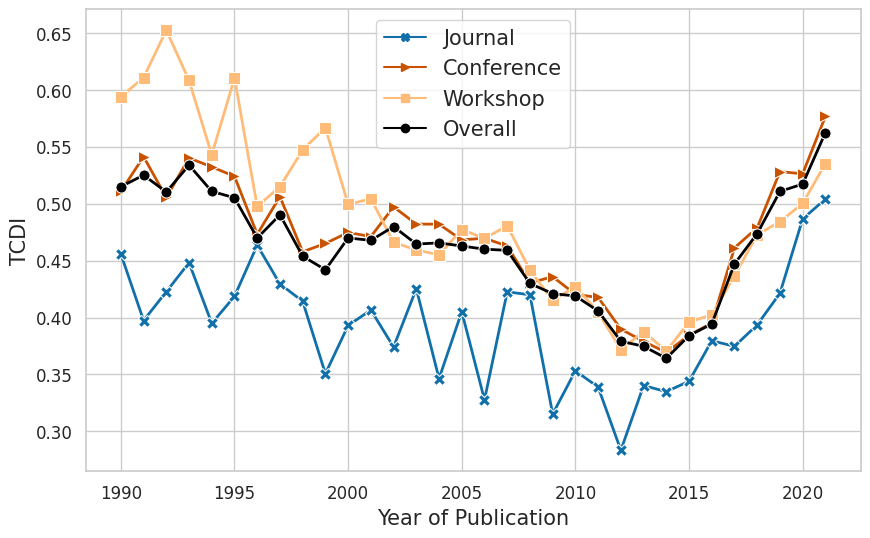

In [77]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

year_citation_fraction_venue = dict()
for venue in ['journal', 'workshop', 'conference']:
  year_citation_fraction_venue[venue] = dict()
  for year in range(1990, 2022):
    frac_list = []
    citation_list = coarse_venue_age[venue]['year2age'][year]
    citation_list = [x for x in citation_list if x <= 20]
    for i in range(20):
      frac = citation_list.count(i)/len(citation_list)
      frac_list.append(frac)
    year_citation_fraction_venue[venue][year] = frac_list


# year_citation_fraction[2022] = [0/30 for x in range(30)]
# year_citation_fraction[2023] = [1/20 for x in range(20)]
# year_citation_fraction[2022][5] = 1

year_venue_gini = dict()
for venue in ['journal', 'workshop', 'conference']:
  year_venue_gini[venue] = dict()
  for year in range(1990, 2022):
    gini_coef = gini(np.array(year_citation_fraction_venue[venue][year]))

    # if(len(coarse_venue_age[venue]['year2age'][year]) <= 1):
    #   var = 0
    # else:
    #   # print(f'Year =  {year} ::  count = {len(year2age[year])} ')
    #   # var = stdev(coarse_venue_age[venue]['year2age'][year])
    #   var = variance(coarse_venue_age[venue]['year2age'][year])
      # var = variance(year2age[year])
    year_venue_gini[venue][year] = gini_coef

overall_df = pd.DataFrame()
for year in range(1990, 2022):
  dict1 = {'AoC': [year_venue_gini["journal"][year]], 'Type': ['Journal'], 'Year of publication': [year]} 
  dict2 = {'AoC': [year_venue_gini["conference"][year]], 'Type': ['Conference'], 'Year of publication': [year]} 
  dict3 = {'AoC': [year_venue_gini["workshop"][year]], 'Type': ['Workshop'], 'Year of publication': [year]} 
  dict4 = {'AoC': [year_gini[year]], 'Type': ['Overall'], 'Year of publication': [year]}

  df1 = pd.DataFrame(dict1)
  df2 = pd.DataFrame(dict2)
  df3 = pd.DataFrame(dict3)
  df4 = pd.DataFrame(dict4)

  df1 = df1.append(df2, ignore_index=True)
  df1 = df1.append(df3, ignore_index=True)
  df1 = df1.append(df4, ignore_index=True)
  overall_df = overall_df.append(df1, ignore_index=True)

# dict4 = {'AoC': [df_aoc], 'Type': ['Overall'], 'Year of publication': [year]}
# df4 = pd.DataFrame(dict4)
# overall_df = overall_df.append(df4, ignore_index=True)

sns.set(font_scale = 8)
sns.set(rc={'figure.figsize':(10,6)})
# b = sns.lineplot(data = overall_df, x='Year of publication', y='AoC', hue='Type', marker="o")
sns.set_style(style='whitegrid')
b = sns.lineplot(data = overall_df, x='Year of publication', y='AoC', hue='Type', palette=['#1170aa', '#c85200', '#ffbc79', 'black'], style='Type', dashes = False, markers=['X', '>', 's', 'o'], linewidth=2, markersize=8 )
# b = sns.lineplot(data = overall_df, x='Year of publication', y='AoC', hue='Type', palette=['#1170aa', '#c85200', '#ffbc79'], style='Type', dashes = False, markers=['X', '>', 's'], linewidth=2, markersize=8 )
b.set_xlabel("Year of Publication",fontsize=15)
b.set_ylabel("TCDI",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper center", frameon=True, fontsize=15)
plt.show()

In [78]:
year_venue_gini

{'journal': {1990: 0.4558411214953272,
  1991: 0.397378640776699,
  1992: 0.42263999999999985,
  1993: 0.448181818181818,
  1994: 0.3948642266824085,
  1995: 0.4185897435897435,
  1996: 0.46349693251533736,
  1997: 0.42947019867549674,
  1998: 0.41425925925925916,
  1999: 0.3506858710562415,
  2000: 0.39300217548948513,
  2001: 0.40659295659295647,
  2002: 0.3741254523522316,
  2003: 0.4252747252747252,
  2004: 0.34637912673056437,
  2005: 0.40513944223107584,
  2006: 0.32772606382978736,
  2007: 0.4225772223532187,
  2008: 0.419961489088575,
  2009: 0.3152489125181247,
  2010: 0.3531906614785993,
  2011: 0.33892045454545455,
  2012: 0.2834454912516824,
  2013: 0.34028731248410876,
  2014: 0.3348914616497829,
  2015: 0.3440270772498009,
  2016: 0.37958766131570676,
  2017: 0.3747309136420525,
  2018: 0.39361493123772096,
  2019: 0.42129671319225587,
  2020: 0.48662071403322715,
  2021: 0.5040123098362558},
 'workshop': {1990: 0.593835616438356,
  1991: 0.6106905710491367,
  1992: 0.652

In [79]:
venue_year_count = dict()
for venue in ['journal', 'workshop', 'conference']:
  venue_year_count[venue] = dict()
  for paper_id in paper2ref.keys():
    if(paper_id not in dict_paper_id_to_venue_coarse.keys()):
      continue
    if(dict_paper_id_to_venue_coarse[paper_id] == venue):
      year, citation_age_list, mean_age = citation_age(paper_id)
      if(year != None):
        if(year not in venue_year_count[venue].keys()):
          venue_year_count[venue][year] = 0
        venue_year_count[venue][year] += 1

In [80]:
total_year_count = dict()
for year in range(1990, 2022):
  total_year_count[year] = len(year2mean_age[year])


KeyError: ignored

In [81]:
print(f" {venue_year_count['journal'][2015] } ---- {venue_year_count['workshop'][2015]} ----- {venue_year_count['conference'][2015]} ")

 139 ---- 983 ----- 1709 


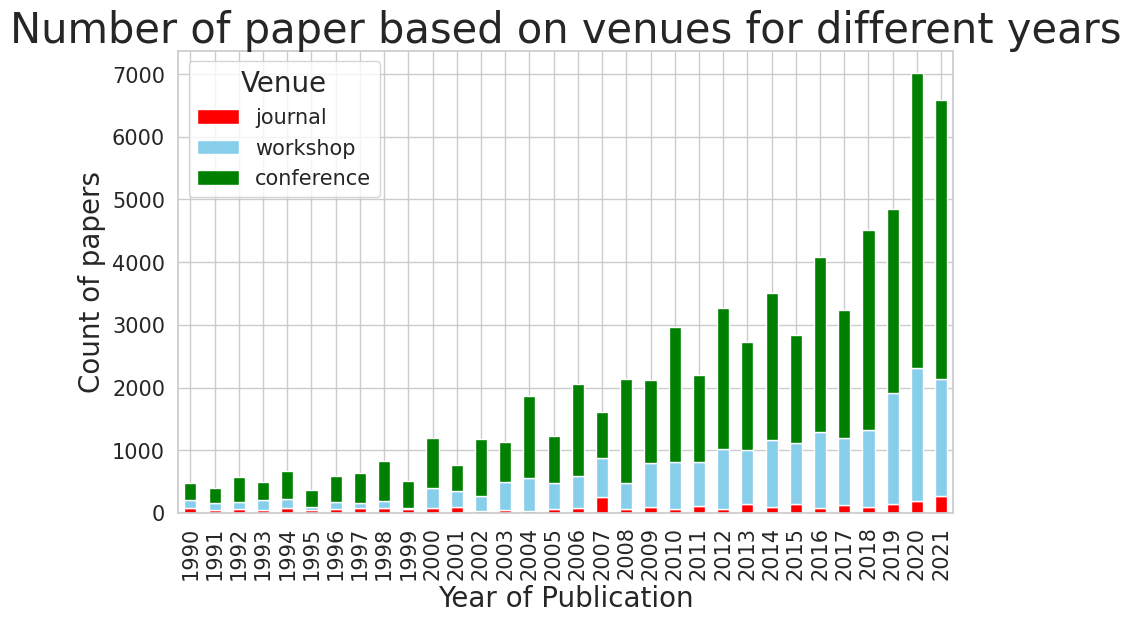

In [82]:
journal_count = [venue_year_count['journal'][year] for year in range(1990, 2022)]
workshop_count = [venue_year_count['workshop'][year] for year in range(1990, 2022)]
conference_count = [venue_year_count['conference'][year] for year in range(1990, 2022)]
# remaining_count = [ (total_year_count[year] - 
#                      venue_year_count['journal'][year] -
#                      venue_year_count['workshop'][year] - 
#                      venue_year_count['conference'][year])  for year in range(1990, 2022)]

df = pd.DataFrame({'journal': journal_count,
                   'workshop': workshop_count,
                   'conference': conference_count},
                  index = range(1990, 2022))

ax = df.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'])
 
# labels for x & y axis
plt.xlabel('Year of Publication',fontsize=20)
plt.ylabel('Count of papers', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
 
# title of plot
plt.title('Number of paper based on venues for different years', fontsize=30)
plt.legend(title='Venue', fontsize='15', title_fontsize='20')
# b.tick_params(axis='both', which='major', labelsize=15)
# plt.legend(title='Venue', fontsize='15', title_fontsize='20')
# plt.xticks(range(1991, 2022))
plt.show()

# y_offset = 4
# # Add labels to each bar.
# for i, total in enumerate(totals):
# ax.text(totals.index[i], total + y_offset, round(total), ha='center',
#         weight='bold')

In [83]:
x = range(1990, 2022)
y = [total_year_count[year] for year in range(1990, 2022)]

# setting figure size by using figure() function 
plt.figure(figsize = (20, 5))
  
# making the bar chart on the data
plt.bar(x, y)
  
# calling the function to add value labels
# for i in range(len(x)):
#   plt.text(i, y[i], y[i], ha = 'center')
  
# giving title to the plot
plt.title("College Admission")
  
# giving X and Y labels
plt.xlabel("Courses")
plt.ylabel("Number of Admissions")
  
# visualizing the plot
plt.show()

KeyError: ignored

In [84]:
import numpy as np 
N = len(range(1990, 2022))
x = range(1990, 2022)
y = [total_year_count[year] for year in range(1990, 2022)]
width = 0.35
ind = np.arange(N)
fig, ax = plt.subplots()

p1 = ax.bar(ind, x, width, label='Men')
p2 = ax.bar(ind, y, width,
            bottom=x, label='Women')

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind, labels=x)
ax.legend()

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

plt.show()

KeyError: ignored

In [85]:


# question X : what is the fraction of citations to articles that are at least ten years old

dict_old_citation_temp = dict()
for paper_id in tqdm.tqdm(paper2ref.keys()):
  if(paper_id in paper2year.keys()):
    year_published = paper2year[paper_id]
    if(year_published not in dict_old_citation_temp.keys()):
      dict_old_citation_temp[year_published] = dict()
      dict_old_citation_temp[year_published]['old'] = 0
      dict_old_citation_temp[year_published]['total'] = 0
    
    reference_list = paper2ref[paper_id]
    for reference in reference_list:
      if(reference in paper_details.keys() and reference in paper2year.keys()):
        reference_year = paper2year[reference]
        age = year_published - reference_year
        
        if(age < 0 ):
          age = 0

        if(age >= 10):
          dict_old_citation_temp[year_published]['old'] += 1
        
        dict_old_citation_temp[year_published]['total'] += 1

dict_old_citation = dict()
for year in dict_old_citation_temp.keys():
  if(year >= 1990):
    dict_old_citation[year] = (dict_old_citation_temp[year]['old'] /dict_old_citation_temp[year]['total'])*100

    

100%|██████████| 73744/73744 [00:01<00:00, 40985.38it/s]


In [86]:
# question X : what is the fraction of citations to articles that are at least ten years old
dict_old_citation_venue_temp = dict()
for venue in ['journal', 'workshop', 'conference']:
  total = 0
  dict_old_citation_venue_temp[venue] = dict()
  for paper_id in paper2ref.keys():
    if(paper_id not in dict_paper_id_to_venue_coarse.keys()):
      continue
    if(dict_paper_id_to_venue_coarse[paper_id] == venue and paper_id in paper2year.keys()):
      year_published = paper2year[paper_id]
      if(year_published not in dict_old_citation_venue_temp[venue].keys()):
        dict_old_citation_venue_temp[venue][year_published] = dict()
        dict_old_citation_venue_temp[venue][year_published]['old'] = 0
        dict_old_citation_venue_temp[venue][year_published]['total'] = 0
      
      reference_list = paper2ref[paper_id]
      for reference in reference_list:
        if(reference in paper_details.keys() and reference in paper2year.keys()):
          reference_year = paper2year[reference]
          age = year_published - reference_year
          total += 1
          if(age < 0 ):
            age = 0
          if(age >= 10):
            dict_old_citation_venue_temp[venue][year_published]['old'] += 1
          
          dict_old_citation_venue_temp[venue][year_published]['total'] += 1

dict_old_citation_venue = dict()
for venue in ['journal', 'workshop', 'conference']:
  dict_old_citation_venue[venue] = dict()
  for year in dict_old_citation_venue_temp[venue].keys():
    if(year >= 1990):
      dict_old_citation_venue[venue][year] = (dict_old_citation_venue_temp[venue][year]['old'] /dict_old_citation_venue_temp[venue][year]['total'])*100

In [87]:
dict_old_citation_venue['workshop'][1999] = 16

<ipython-input-88-8f8742714c59>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)
<ipython-input-88-8f8742714c59>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df3, ignore_index=True)
<ipython-input-88-8f8742714c59>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df4, ignore_index=True)
<ipython-input-88-8f8742714c59>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-88-8f8742714c59>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

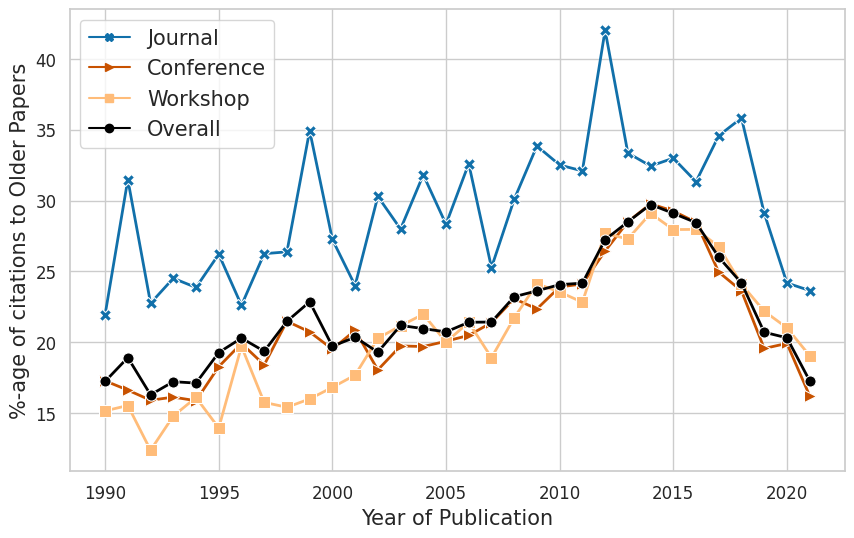

In [88]:
overall_df = pd.DataFrame()
for year in range(1990, 2022):
  dict1 = {'OlderPaper': [dict_old_citation_venue["journal"][year]], 'Type': ['Journal'], 'Year of publication': [year]} 
  dict2 = {'OlderPaper': [dict_old_citation_venue["conference"][year]], 'Type': ['Conference'], 'Year of publication': [year]} 
  dict3 = {'OlderPaper': [dict_old_citation_venue["workshop"][year]], 'Type': ['Workshop'], 'Year of publication': [year]} 
  dict4 = {'OlderPaper': [dict_old_citation[year]], 'Type': ['Overall'], 'Year of publication': [year]}

  df1 = pd.DataFrame(dict1)
  df2 = pd.DataFrame(dict2)
  df3 = pd.DataFrame(dict3)
  df4 = pd.DataFrame(dict4)

  df1 = df1.append(df2, ignore_index=True)
  df1 = df1.append(df3, ignore_index=True)
  df1 = df1.append(df4, ignore_index=True)
  overall_df = overall_df.append(df1, ignore_index=True)

# dict4 = {'AoC': [df_aoc], 'Type': ['Overall'], 'Year of publication': [year]}
# df4 = pd.DataFrame(dict4)
# overall_df = overall_df.append(df4, ignore_index=True)

sns.set(font_scale = 8)
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style(style='whitegrid')

b = sns.lineplot(data = overall_df, x='Year of publication', y='OlderPaper', hue='Type', palette=['#1170aa', '#c85200', '#ffbc79', 'black'], style='Type', dashes = False, markers=['X', '>', 's', 'o'], linewidth=2, markersize=8 )
b.set_xlabel("Year of Publication",fontsize=15)
b.set_ylabel("%-age of citations to Older Papers",fontsize=15)
b.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper left", frameon=True, fontsize=15)
# st = axes_style("whitegrid")
plt.show()

In [89]:
with open('/content/drive/MyDrive/ColabNotebooks/PaperAge/paperid_citationcount.json', 'r') as fp:
    dict_paperid_citationCount = json.load(fp)

FileNotFoundError: ignored

In [90]:
with open('/content/drive/MyDrive/ColabNotebooks/PaperAge/paperid_influentialcitationcount.json', 'r') as fp:
    dict_paperid_citationCount = json.load(fp)

FileNotFoundError: ignored

In [91]:
#computing the RQ: 7 Do well-cited papers (rough proxy for high impact) cite more old papers and have more citation diversity?
import statistics 
dict_citation_dist = dict()
dict_citation_dist["0"] = dict()
dict_citation_dist["1-9"] = dict()
dict_citation_dist["10-49"] = dict()
dict_citation_dist["50-99"] = dict()
dict_citation_dist["100-499"] = dict()
dict_citation_dist["500-999"] = dict()
dict_citation_dist["1000-1999"] = dict()
dict_citation_dist["2000-4999"] = dict()
dict_citation_dist["5000+"] = dict()

for bucket in dict_citation_dist.keys():
  dict_citation_dist[bucket]['mean_list'] = []
  dict_citation_dist[bucket]['overall_list'] = []

for paper_id in tqdm.tqdm(paper2ref.keys()):
  if(paper_id in dict_paperid_citationCount.keys()):
    count_citation = dict_paperid_citationCount[paper_id]
    identifier_bucket = ""
    if(count_citation == 0):
      identifier_bucket = "0"
    elif(count_citation >= 1 and count_citation <= 9):
      identifier_bucket = "1-9"
    elif(count_citation >= 10 and count_citation <= 49):
      identifier_bucket = "10-49"
    elif(count_citation >= 50 and count_citation <= 99):
      identifier_bucket = "50-99"
    elif(count_citation >= 100 and count_citation <= 499):
      identifier_bucket = "100-499"
    elif(count_citation >= 500 and count_citation <= 999):
      identifier_bucket = "500-999"
    elif(count_citation >= 1000 and count_citation <= 1999):
      identifier_bucket = "1000-1999"
    elif(count_citation >= 2000 and count_citation <= 4999):
      identifier_bucket = "2000-4999"
    elif(count_citation >= 5000):
      identifier_bucket = "5000+"
    

    year, citation_age_list, mean_age = citation_age(paper_id)
    if(mean_age != None):
      dict_citation_dist[identifier_bucket]['mean_list'].append(mean_age)
      dict_citation_dist[identifier_bucket]['overall_list'].extend(citation_age_list)
    
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

def compute_gini(citation_list):
  citation_list = [x for x in citation_list if x <= 20]
  frac_list = []
  for i in range(20):
    frac = citation_list.count(i)/len(citation_list)
    frac_list.append(frac)
  
  return gini(np.array(frac_list))


for bucket in dict_citation_dist.keys():
  dict_citation_dist[bucket]['mean'] = sum(dict_citation_dist[bucket]['mean_list'])/len(dict_citation_dist[bucket]['mean_list'])
  dict_citation_dist[bucket]['median'] = statistics.median(dict_citation_dist[bucket]['mean_list'])
  dict_citation_dist[bucket]['gini'] = compute_gini(dict_citation_dist[bucket]['overall_list'])

100%|██████████| 73744/73744 [00:01<00:00, 45432.35it/s]


In [92]:
for bucket in dict_citation_dist.keys():
  print(f"Bucket = {bucket} Count.= {len(dict_citation_dist[bucket]['mean_list'])} ")

Bucket = 0 Count.= 5559 
Bucket = 1-9 Count.= 26794 
Bucket = 10-49 Count.= 21926 
Bucket = 50-99 Count.= 4843 
Bucket = 100-499 Count.= 3860 
Bucket = 500-999 Count.= 332 
Bucket = 1000-1999 Count.= 123 
Bucket = 2000-4999 Count.= 71 
Bucket = 5000+ Count.= 35 


<ipython-input-93-b5eacacae025>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-93-b5eacacae025>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-93-b5eacacae025>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-93-b5eacacae025>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-93-b5eacacae025>:5: FutureWarning: The frame.append method is deprecated and will be 

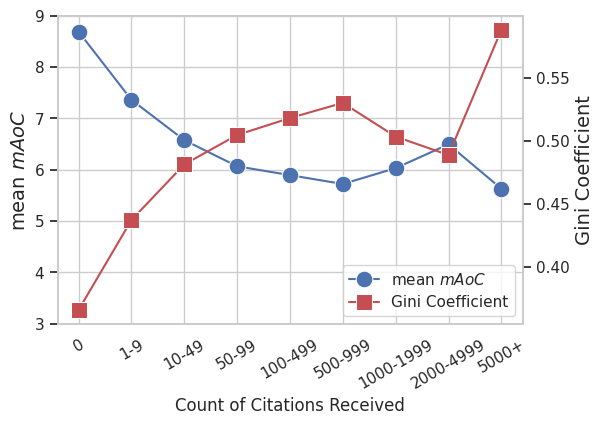

In [93]:
overall_df = pd.DataFrame()
for bucket in dict_citation_dist.keys():
  dict1 = {'Mean': [dict_citation_dist[bucket]["mean"]], 'Gini': [dict_citation_dist[bucket]["gini"]], 'Count of Citations Received': [bucket]} 
  df1 = pd.DataFrame(dict1)
  overall_df = overall_df.append(df1, ignore_index=True)

sns.set(font_scale = 8)
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style(style='whitegrid')
ax1 = sns.lineplot(data = overall_df,  x='Count of Citations Received', y = "Mean", color="b", marker='o', markersize=12)
ax1.set_ylabel('mean $\mathit{mAoC}$')
ax1.set_ylim(3, 9)
# ax1.grid(False)
# ax1.legend(['Mean'], loc="upper left")
ax1.yaxis.label.set_fontsize(14)
ax1.tick_params(axis='x', rotation=30)
# ax1.tick_params(axis='y', colors='blue', labelsize=14)

ax2 = ax1.twinx()
sns.lineplot(data=overall_df,  x='Count of Citations Received', y = "Gini", color="r", ax=ax2, marker='s', markersize=12)
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('Gini Coefficient')
# ax2.legend(['Gini Coefficient'], loc="upper left")
ax2.yaxis.label.set_fontsize(14)
# plt.legend(loc="upper left")

ax2.legend(
    [ax1.get_lines()[0], ax2.get_lines()[0]], 
    ['mean $\mathit{mAoC}$','Gini Coefficient'], 
    loc="lower right"
)

plt.savefig('r7_diversity.png', edgecolor='none',transparent=True)

In [94]:
def compute_citability(start_year, end_year):
  #computing the RQ: 7 Do well-cited papers (rough proxy for high impact) cite more old papers and have more citation diversity?
  import statistics 
  dict_citation_dist = dict()
  dict_citation_dist["0"] = dict()
  dict_citation_dist["1-9"] = dict()
  dict_citation_dist["10-49"] = dict()
  dict_citation_dist["50-99"] = dict()
  dict_citation_dist["100-499"] = dict()
  dict_citation_dist["500-999"] = dict()
  dict_citation_dist["1000-1999"] = dict()
  # dict_citation_dist["2000-4999"] = dict()
  dict_citation_dist["2000+"] = dict()

  for bucket in dict_citation_dist.keys():
    dict_citation_dist[bucket]['mean_list'] = []
    dict_citation_dist[bucket]['overall_list'] = []

  for paper_id in tqdm.tqdm(paper2ref.keys()):
    if(paper_id in paper2year.keys()):
      year_published = paper2year[paper_id]
      if(paper_id in dict_paperid_citationCount.keys() and year_published >= start_year and year_published <= end_year):
        count_citation = dict_paperid_citationCount[paper_id]
        identifier_bucket = ""
        if(count_citation == 0):
          identifier_bucket = "0"
        elif(count_citation >= 1 and count_citation <= 9):
          identifier_bucket = "1-9"
        elif(count_citation >= 10 and count_citation <= 49):
          identifier_bucket = "10-49"
        elif(count_citation >= 50 and count_citation <= 99):
          identifier_bucket = "50-99"
        elif(count_citation >= 100 and count_citation <= 499):
          identifier_bucket = "100-499"
        elif(count_citation >= 500 and count_citation <= 999):
          identifier_bucket = "500-999"
        elif(count_citation >= 1000 and count_citation <= 1999):
          identifier_bucket = "1000-1999"
        # elif(count_citation >= 2000 and count_citation <= 4999):
        #   identifier_bucket = "2000-4999"
        elif(count_citation >= 2000):
          identifier_bucket = "2000+"
          

        year, citation_age_list, mean_age = citation_age(paper_id)
        if(mean_age != None):
          dict_citation_dist[identifier_bucket]['mean_list'].append(mean_age)
          dict_citation_dist[identifier_bucket]['overall_list'].extend(citation_age_list)
  for bucket in dict_citation_dist.keys():
    print(f"Bucket = {bucket} Count.= {len(dict_citation_dist[bucket]['mean_list'])} ")
      
  def gini(x):
      total = 0
      for i, xi in enumerate(x[:-1], 1):
          total += np.sum(np.abs(xi - x[i:]))
      return total / (len(x)**2 * np.mean(x))

  def compute_gini(citation_list):
    citation_list = [x for x in citation_list if x <= 20]
    frac_list = []
    for i in range(20):
      frac = citation_list.count(i)/len(citation_list)
      frac_list.append(frac)
    
    return gini(np.array(frac_list))


  for bucket in dict_citation_dist.keys():
    dict_citation_dist[bucket]['mean'] = sum(dict_citation_dist[bucket]['mean_list'])/len(dict_citation_dist[bucket]['mean_list'])
    dict_citation_dist[bucket]['median'] = statistics.median(dict_citation_dist[bucket]['mean_list'])
    dict_citation_dist[bucket]['gini'] = compute_gini(dict_citation_dist[bucket]['overall_list'])
  
  overall_df = pd.DataFrame()
  for bucket in dict_citation_dist.keys():
    dict1 = {'Mean': [dict_citation_dist[bucket]["mean"]], 'Gini': [dict_citation_dist[bucket]["gini"]], 'Count of Citations Received': [bucket]} 
    df1 = pd.DataFrame(dict1)
    overall_df = overall_df.append(df1, ignore_index=True)

  sns.set(font_scale = 8)
  sns.set(rc={'figure.figsize':(6,4)})
  sns.set_style(style='whitegrid')
  ax1 = sns.lineplot(data = overall_df,  x='Count of Citations Received', y = "Mean", color="b", marker='o', markersize=12)
  ax1.set_ylabel('mean $\mathit{mAoC}$')
  # ax1.set_ylim(5, 13)
  # ax1.grid(False)
  # ax1.legend(['Mean'], loc="upper left")
  ax1.yaxis.label.set_fontsize(14)
  ax1.tick_params(axis='x', rotation=30)
  # ax1.tick_params(axis='y', colors='blue', labelsize=14)

  ax2 = ax1.twinx()
  sns.lineplot(data=overall_df,  x='Count of Citations Received', y = "Gini", color="r", ax=ax2, marker='s', markersize=12)
  ax2.grid(False) # turn off grid #2
  ax2.set_ylabel('Gini Coefficient')
  # ax2.legend(['Gini Coefficient'], loc="upper left")
  ax2.yaxis.label.set_fontsize(14)
  # plt.legend(loc="upper left")

  ax2.legend(
      [ax1.get_lines()[0], ax2.get_lines()[0]], 
      ['mean $\mathit{mAoC}$','Gini Coefficient'], 
      loc="lower right"
  )
  # ax2.set_title(f"Citation Diversity and mAoC for {start_year} to {end_year}",fontsize=12)
  citation_count_list = [0, 5,25, 75, 250, 750,1500,2000]
  gini_list = list(overall_df['Gini'])
  from scipy.stats import spearmanr
  rho, p = spearmanr(citation_count_list, gini_list)
  print(f'For Gini: Coefficent = {rho} P-value = {p}')

100%|██████████| 73744/73744 [00:00<00:00, 475065.59it/s]
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: Fu

Bucket = 0 Count.= 457 
Bucket = 1-9 Count.= 1813 
Bucket = 10-49 Count.= 1714 
Bucket = 50-99 Count.= 515 
Bucket = 100-499 Count.= 496 
Bucket = 500-999 Count.= 45 
Bucket = 1000-1999 Count.= 26 
Bucket = 2000+ Count.= 21 
For Gini: Coefficent = -0.1666666666666667 P-value = 0.693238811728395


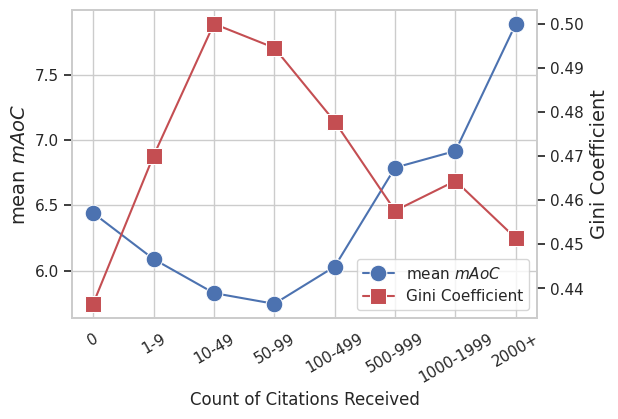

In [95]:
compute_citability(1990, 2000)

100%|██████████| 73744/73744 [00:00<00:00, 232489.34it/s]
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: Fu

Bucket = 0 Count.= 1062 
Bucket = 1-9 Count.= 5354 
Bucket = 10-49 Count.= 5804 
Bucket = 50-99 Count.= 1517 
Bucket = 100-499 Count.= 1296 
Bucket = 500-999 Count.= 105 
Bucket = 1000-1999 Count.= 26 
Bucket = 2000+ Count.= 34 
For Gini: Coefficent = 1.0 P-value = 0.0


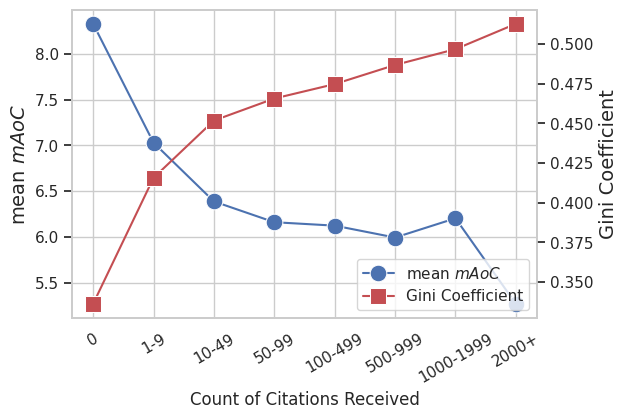

In [96]:
compute_citability(2001, 2010)

100%|██████████| 73744/73744 [00:00<00:00, 149195.05it/s]
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(df1, ignore_index=True)
<ipython-input-94-15c0728ea701>:77: Fu

Bucket = 0 Count.= 1453 
Bucket = 1-9 Count.= 7090 
Bucket = 10-49 Count.= 6272 
Bucket = 50-99 Count.= 1275 
Bucket = 100-499 Count.= 954 
Bucket = 500-999 Count.= 94 
Bucket = 1000-1999 Count.= 49 
Bucket = 2000+ Count.= 27 
For Gini: Coefficent = 0.9761904761904763 P-value = 3.3143960262001043e-05


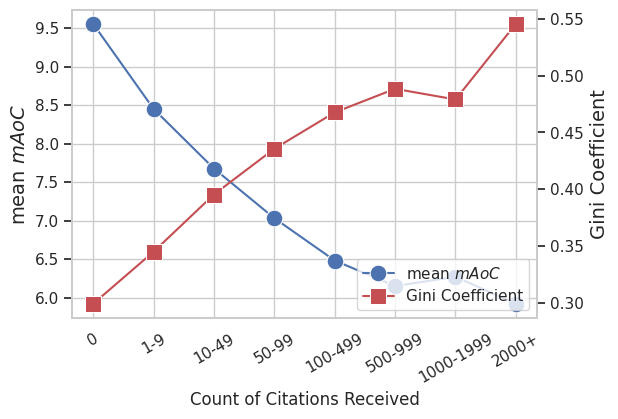

In [97]:
compute_citability(2011, 2016)

In [98]:

#compute Spearman Corelation Coefficient between the #citations and the mean/median citation 
citation_count_list_mean = []
list_mean = []

citation_count_list_median = []
list_median = []

for paper_id in tqdm.tqdm(paper2ref.keys()):
  if(paper_id in dict_paperid_citationCount.keys()):
    count_citation = dict_paperid_citationCount[paper_id]
    year, citation_age_list, mean_age = citation_age(paper_id)
    if(count_citation > 0):
      if(mean_age != None):
        citation_count_list_mean.append(count_citation)
        list_mean.append(mean_age)
      
      if(len(citation_age_list) > 0):
        median_age = statistics.median(citation_age_list)
        citation_count_list_median.append(count_citation)
        list_median.append(median_age)

100%|██████████| 73744/73744 [00:02<00:00, 28990.54it/s]


In [99]:
len(citation_count_list_mean)

57984

In [100]:
from scipy.stats import spearmanr
rho_mean, p_mean = spearmanr(citation_count_list_mean, list_mean)
rho_median, p_median = spearmanr(citation_count_list_median, list_median)
print(f'For Mean: Coefficent = {rho_mean} P-value = {p_mean}')
print(f'For Median: Coefficent = {rho_median} P-value = {p_median}')

For Mean: Coefficent = -0.1411409321148461 P-value = 1.055352872142608e-255
For Median: Coefficent = -0.17120208954858834 P-value = 0.0


In [101]:
citation_count_string = overall_df['Count of Citations Received']
citation_count_list = [0, 5,25, 75, 250, 750,1500,3500, 5000]
gini_list = list(overall_df['Gini'])


from scipy.stats import spearmanr
rho, p = spearmanr(citation_count_list, gini_list)
print(f'For Mean: Coefficent = {rho} P-value = {p}')

For Mean: Coefficent = 0.7333333333333334 P-value = 0.02455415007146968


Spearman's correlation coefficient for Gini & Mean of Citation bucket

1990 - 2000: Coefficent = -0.1666666666666667 P-value = 0.693238811728395
2001 - 2010: Coefficent = 1.0 P-value = 0.0
2011 - 2016: Coefficent = 0.9761904761904763 P-value = 3.3143960262001043e-05

```
# This is formatted as code
```



In [102]:
paper_details['c3fb6056ca1ec3f7cfe57103712531fdbfe69e03']['title'].lower()

'syntactic perturbations reveal representational correlates of hierarchical phrase structure in pretrained language models'

In [103]:
def compute_citability_subfield(subfield_name):
  #computing the RQ: 7 Do well-cited papers (rough proxy for high impact) cite more old papers and have more citation diversity?
  import statistics 
  dict_citation_dist = dict()
  dict_citation_dist["0"] = dict()
  dict_citation_dist["1-9"] = dict()
  dict_citation_dist["10-49"] = dict()
  dict_citation_dist["50-99"] = dict()
  dict_citation_dist["100-499"] = dict()
  dict_citation_dist["500-999"] = dict()
  dict_citation_dist["1000-1999"] = dict()
  # dict_citation_dist["2000-4999"] = dict()
  dict_citation_dist["2000+"] = dict()

  for bucket in dict_citation_dist.keys():
    dict_citation_dist[bucket]['mean_list'] = []
    dict_citation_dist[bucket]['overall_list'] = []

  for paper_id in tqdm.tqdm(paper2ref.keys()):
    if(paper_id in paper2year.keys() and paper_id in paper_details.keys() and subfield_name.lower() in paper_details[paper_id]['title'].lower()):
      year_published = paper2year[paper_id]
      if(paper_id in dict_paperid_citationCount.keys()):
        count_citation = dict_paperid_citationCount[paper_id]
        identifier_bucket = ""
        if(count_citation == 0):
          identifier_bucket = "0"
        elif(count_citation >= 1 and count_citation <= 9):
          identifier_bucket = "1-9"
        elif(count_citation >= 10 and count_citation <= 49):
          identifier_bucket = "10-49"
        elif(count_citation >= 50 and count_citation <= 99):
          identifier_bucket = "50-99"
        elif(count_citation >= 100 and count_citation <= 499):
          identifier_bucket = "100-499"
        elif(count_citation >= 500 and count_citation <= 999):
          identifier_bucket = "500-999"
        elif(count_citation >= 1000 and count_citation <= 1999):
          identifier_bucket = "1000-1999"
        # elif(count_citation >= 2000 and count_citation <= 4999):
        #   identifier_bucket = "2000-4999"
        elif(count_citation >= 2000):
          identifier_bucket = "2000+"
          

        year, citation_age_list, mean_age = citation_age(paper_id)
        if(mean_age != None):
          dict_citation_dist[identifier_bucket]['mean_list'].append(mean_age)
          dict_citation_dist[identifier_bucket]['overall_list'].extend(citation_age_list)
  for bucket in dict_citation_dist.keys():
    print(f"Bucket = {bucket} Count.= {len(dict_citation_dist[bucket]['mean_list'])} ")
      
  def gini(x):
      total = 0
      for i, xi in enumerate(x[:-1], 1):
          total += np.sum(np.abs(xi - x[i:]))
      return total / (len(x)**2 * np.mean(x))

  def compute_gini(citation_list):
    citation_list = [x for x in citation_list if x <= 20]
    frac_list = []
    for i in range(20):
      frac = citation_list.count(i)/len(citation_list)
      frac_list.append(frac)
    
    return gini(np.array(frac_list))


  for bucket in dict_citation_dist.keys():
    dict_citation_dist[bucket]['mean'] = sum(dict_citation_dist[bucket]['mean_list'])/len(dict_citation_dist[bucket]['mean_list'])
    dict_citation_dist[bucket]['median'] = statistics.median(dict_citation_dist[bucket]['mean_list'])
    dict_citation_dist[bucket]['gini'] = compute_gini(dict_citation_dist[bucket]['overall_list'])
  
  overall_df = pd.DataFrame()
  for bucket in dict_citation_dist.keys():
    dict1 = {'Mean': [dict_citation_dist[bucket]["mean"]], 'Gini': [dict_citation_dist[bucket]["gini"]], 'Count of Citations Received': [bucket]} 
    df1 = pd.DataFrame(dict1)
    # overall_df = overall_df.append(df1, ignore_index=True)
    overall_df = pd.concat([overall_df, df1], ignore_index=True)

  sns.set(font_scale = 8)
  sns.set(rc={'figure.figsize':(6,4)})
  sns.set_style(style='whitegrid')
  ax1 = sns.lineplot(data = overall_df,  x='Count of Citations Received', y = "Mean", color="b", marker='o', markersize=12)
  ax1.set_ylabel('mean $\mathit{mAoC}$')
  # ax1.set_ylim(5, 13)
  # ax1.grid(False)
  # ax1.legend(['Mean'], loc="upper left")
  ax1.yaxis.label.set_fontsize(14)
  ax1.tick_params(axis='x', rotation=30)
  # ax1.tick_params(axis='y', colors='blue', labelsize=14)

  ax2 = ax1.twinx()
  sns.lineplot(data=overall_df,  x='Count of Citations Received', y = "Gini", color="r", ax=ax2, marker='s', markersize=12)
  ax2.grid(False) # turn off grid #2
  ax2.set_ylabel('Gini Coefficient')
  # ax2.legend(['Gini Coefficient'], loc="upper left")
  ax2.yaxis.label.set_fontsize(14)
  # plt.legend(loc="upper left")

  ax2.legend(
      [ax1.get_lines()[0], ax2.get_lines()[0]], 
      ['mean $\mathit{mAoC}$','Gini Coefficient'], 
      loc="lower right"
  )
  # ax2.set_title(f"Citation Diversity and mAoC for {start_year} to {end_year}",fontsize=12)
  citation_count_list = [0, 5,25, 75, 250, 750,1500,2000]
  gini_list = list(overall_df['Gini'])
  from scipy.stats import spearmanr
  rho, p = spearmanr(citation_count_list, gini_list)
  print(f'For Gini: Coefficent = {rho} P-value = {p}')

In [104]:
compute_citability_subfield('global vector')

100%|██████████| 73744/73744 [00:00<00:00, 548078.40it/s]

Bucket = 0 Count.= 0 
Bucket = 1-9 Count.= 1 
Bucket = 10-49 Count.= 3 
Bucket = 50-99 Count.= 0 
Bucket = 100-499 Count.= 0 
Bucket = 500-999 Count.= 0 
Bucket = 1000-1999 Count.= 0 
Bucket = 2000+ Count.= 1 


ZeroDivisionError: ignored